
![Urban vs Rural](Images/IntroSlide.png)


# Do urban counties have better health outcomes in Texas?

Using the [Count Health rankings](https://www.countyhealthrankings.org/app/texas/2019/downloads) Texas 2019 dataset and the [CDC NCHS Urban Rural Classification System](https://www.cdc.gov/nchs/data_access/urban_rural.htm#Data_Files_and_Documentation) we will seek to reject the null hypothesis that which county you live in has no impact on your health outcome. Next we will explore the factors that influence the differences between urban and rural counties in Texas. Finally we will give a ranking of the statistically top 5 and bottom 5 counties regarding health outcomes (as measured by the Age-Adjusted Mortality Rate).

### Import dependencies

In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import zscore
from scipy.stats import stats
import os
import gmaps
import seaborn as sns
import re

from statsmodels.compat import lzip
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Import API key from a file that is ignored by Git (.gitignore file) so the key isn't exposed to the public
from config import gkey

# Configure gmaps
gmaps.configure(api_key=gkey)

# Store County Health Rankings Excel file data into DataFrames

* Load the excel file imported from https://www.countyhealthrankings.org/app/texas/2019/measure/outcomes/144/description?sort=desc-2

## Read in the Ranked Measure Data sheets eliminating columns and extra headers
* Make a list of available columns to decide what we don't want
* Formulate a regex expression to match unwanted columns so we don't import them
* Create a list of only wanted columns to be used for the usecols argument in the read_excel pandas method
* Set FIPS to be the index (since it is a unique code for each county it is a primary key)
* Eliminate any row without a county name (A summary row for the entire state of Texas is in the worksheet)

### First determine and review the available sheets in the Excel file

In [2]:
# create a path variable to the downloaded excel file
path = "data/2019 County Health Rankings Texas Data - v1_0.xls"

# Get the available sheets in the excel file and put into a list to determine which sheets to download
sheets = pd.ExcelFile(path).sheet_names
sheets

['Introduction',
 'Outcomes & Factors Rankings',
 'Outcomes & Factors SubRankings',
 'Ranked Measure Data',
 'Additional Measure Data',
 'Ranked Measure Sources & Years',
 'Addtl Measure Sources & Years']

### Review and decide what columns we want from the 'Ranked Measure Data' Sheet

In [3]:
# Get the 'Ranked Measure Data' sheet using the sheets list above and rejecting the top header row
rmd = pd.read_excel(path, header=[1], sheet_name=sheets[3])

# View the columns and decide what we don't want
col1 = [col for col in rmd.columns] 
col1.sort()
col1

['# Alcohol-Impaired Driving Deaths',
 '# Associations',
 '# Chlamydia Cases',
 '# Dentists',
 '# Driving Deaths',
 '# Households',
 '# Injury Deaths',
 '# Mental Health Providers',
 '# Primary Care Physicians',
 '# Single-Parent Households',
 '# Some College',
 '# Unemployed',
 '# Uninsured',
 '# Workers who Drive Alone',
 '% Alcohol-Impaired',
 '% Children in Poverty',
 '% Children in Poverty (Black)',
 '% Children in Poverty (Hispanic)',
 '% Children in Poverty (White)',
 '% Drive Alone',
 '% Drive Alone (Black)',
 '% Drive Alone (Hispanic)',
 '% Drive Alone (White)',
 '% Excessive Drinking',
 '% Fair/Poor',
 '% LBW',
 '% LBW (Black)',
 '% LBW (Hispanic)',
 '% LBW (White)',
 '% Long Commute - Drives Alone',
 '% Obese',
 '% Physically Inactive',
 '% Screened',
 '% Screened (Black)',
 '% Screened (Hispanic)',
 '% Screened (White)',
 '% Severe Housing Problems',
 '% Single-Parent Households',
 '% Smokers',
 '% Some College',
 '% Unemployed',
 '% Uninsured',
 '% Vaccinated',
 '% Vaccina

#### After review we decide we don't want the 95% CI, Z-score, State and Unreliable columns
* It is always a good data science practice to not import a column named 'unreliable'

### Use a regex filter to only import the columns we want from the 'Ranked Measure Data' sheet

In [4]:
# Create a regular expression to match unwanted columns
regex = '^Z|95|State|Unreliable'

# Use a list comprehension to make a list of columns that don't match the regex (a failed regex match returns 'None')
cols = [col for col in rmd.columns if re.match(regex,col) is None]

# Create a dataframe of the desired columns and set 'FIPS' to the index
rmd_df = pd.read_excel(path, header=[1], sheet_name=sheets[3],usecols=cols,index_col='FIPS')

# Drop any row that has NaN as County value
rmd_df = rmd_df[pd.notnull(rmd_df['County'])]

# Get the shape of the dataframe to keep track of how many rows and columns we are starting with
print(f'shape of rmd_df: {rmd_df.shape}')

shape of rmd_df: (254, 86)


### Review and decide what columns we want from the 'Additional Measure Data' Sheet

In [5]:
# Get the 'Additional Measure Data' sheet using the sheets list above for the zero indexed number in the list
amd = pd.read_excel(path, header=[1], sheet_name=sheets[4])

# View the columns and decide what we don't want
colList = [col for col in amd.columns] 
colList

['FIPS',
 'State',
 'County',
 'Life Expectancy',
 '95% CI - Low',
 '95% CI - High',
 'Life Expectancy (Black)',
 'Life Expectancy (Hispanic)',
 'Life Expectancy (White)',
 '# Deaths',
 'Age-Adjusted Mortality',
 '95% CI - Low.1',
 '95% CI - High.1',
 'Age-Adjusted Mortality (Black)',
 'Age-Adjusted Mortality (Hispanic)',
 'Age-Adjusted Mortality (White)',
 '# Deaths.1',
 'Child Mortality Rate',
 '95% CI - Low.2',
 '95% CI - High.2',
 'Child Mortality Rate (Black)',
 'Child Mortality Rate (Hispanic)',
 'Child Mortality Rate (White)',
 '# Deaths.2',
 'Infant Mortality Rate',
 '95% CI - Low.3',
 '95% CI - High.3',
 'Infant Mortality Rate (Black)',
 'Infant Mortality Rate (Hispanic)',
 'Infant Mortality Rate (White)',
 '% Frequent Physical Distress',
 '95% CI - Low.4',
 '95% CI - High.4',
 '% Frequent Mental Distress',
 '95% CI - Low.5',
 '95% CI - High.5',
 '% Diabetic',
 '95% CI - Low.6',
 '95% CI - High.6',
 '# HIV Cases',
 'HIV Prevalence Rate',
 '# Food Insecure',
 '% Food Insecure',

### Use a regex filter to only import the columns we want from the 'Ranked Measure Data' sheet

In [6]:
# Create a regular expression to match unwanted columns
regex = '^Z|95|State|Unreliable'

# Use a list comprehension to make a list of columns that don't match the regex (a failed regex match returns 'None')
cols = [col for col in amd.columns if re.match(regex,col) is None]

# Create a dataframe of the desired columns and set 'County' to the index
amd_df = pd.read_excel(path, header=[1], sheet_name=sheets[4],usecols=cols,set_index='FIPS')

# Drop any row that has Nan as County value
amd_df = amd_df[pd.notnull(amd_df['County'])]

# Get the shape of the dataframe to keep track of how many rows and columns we are starting with
print(f'shape of rmd_df: {amd_df.shape}')

shape of rmd_df: (254, 76)


### Merge the two dataframes on FIPS as key

In [7]:
# Merge the rmd and amd dataframes using inner join on County column (index)
merged_df = pd.merge(rmd_df,amd_df, how='inner', on='FIPS')

# Get the shape of the dataframe to keep track of how many rows and columns we are starting with
print(f'shape of merged_df: {merged_df.shape}')
#merged_df.head(1)

shape of merged_df: (254, 162)


The number of columns appears to be correct: 86 + 76 = 162, and we didn't lose any rows (254)

### After a merge often we have _x and _y columns created that need to be consolidated

First identify them and then drop half of them and rename the remainder

In [8]:
# View the columns that end in '_x' or '_y'
regex2 = '.*_x$|.*_y$'
xcols = [col for col in merged_df.columns if re.match(regex2,col) is not None]
xcols

['County_x',
 '# Uninsured_x',
 '% Uninsured_x',
 'Population_x',
 'County_y',
 '# Uninsured_y',
 '% Uninsured_y',
 'Population_y']

In [9]:
# Drop the duplicate _y columns
regex3 = '.*_y$'
merged_df.drop([col for col in merged_df.columns if re.match(regex3,col) is not None],axis=1, inplace=True)

# Check shape of dataframe to ensure we didn't lose more columns than we expected
print(merged_df.shape)

(254, 158)


We started with 162 columns and expected to drop 4 for a remainder of 158

In [10]:
# Rename the columns to eliminate the '_x' leftover from the join
merged_df.rename(columns = {'FIPS_x':'FIPS',\
                                        '# Uninsured_x':'# Uninsured',\
                                        '% Uninsured_x':'% Uninsured',\
                                        'Population_x':'Population'},\
                                         inplace=True)

## Store NCHS Urban Rural Classification System Excel file results into DataFrame

* Load the excel file imported from https://www.cdc.gov/nchs/data_access/urban_rural.htm#Data_Files_and_Documentation
* No description or label was given in the 'NCHS URCS' - only numbers 1-6. Reading the file documentation gave this information, so an excel sheet was created and a VLOOKUP mapped the names and descriptions to the classification numbers. The result excel file will be imported and joined to the merged_df

### First determine and review the available sheets in the Excel file

In [11]:
# create a path variable to the downloaded excel file
path2 = 'data/NCHS Urban Rural Classification System.xlsx'

# Get the available sheets in the excel file and put into a list
sheets2 = pd.ExcelFile(path2).sheet_names
print(sheets2)

['URCS', 'Legend']


In [12]:
# Get the 'URCS' sheet using the sheets list above
cs = pd.read_excel(path2)

# View the columns and decide what we don't want
cs.columns

Index(['FIPS code', 'State Abr.', 'County name', 'CBSA title', 'CBSA 2012 pop',
       'County 2012 pop', '2013 code', '2006 code', '1990-based code', 'URCS',
       'URCS Name', 'URCS description'],
      dtype='object')

We only want 4 of the columns available

In [13]:
# Get the 'URCS' sheet using the columns list above
urcs = pd.read_excel(path2,usecols=['FIPS code','URCS','URCS Name','URCS description'],index_col=0)

# Get the shape of the dataframe to keep track of how many rows and columns we are starting with
print(f'shape of urcs: {urcs.shape}')

shape of urcs: (3149, 3)


In [14]:
# Drop any row that has Nan as an index value
urcs = urcs.loc[urcs.index.dropna()]

# Get the shape of the dataframe to see if we lost any rows
print(f'shape of urcs: {urcs.shape}')

shape of urcs: (3149, 3)


We didn't lose any rows

In [15]:
# Check that all FIPS in the merged_df are in the urcs.index (urcs index has ALL counties in USA not just Texas)
print(f"merged_df FIPS:{[mips for mips in merged_df['FIPS'] if mips not in urcs.index]} not found in urcs.index")

merged_df FIPS:[] not found in urcs.index


The check resulted in us not finding any missing FIPS numbers - which is good.

In [16]:
# Rename the index 'FIPS code' to FIPS
urcs.rename_axis('FIPS', axis=0, inplace=True)

# Verifiy that the column name change took place
urcs.head(1)

,URCS,URCS Name,URCS description
FIPS,,,
1073,Urban,Large central metro,"NCHS-defined ""central"" counties of MSAs of 1 m..."


## Merge the NCHS URCS data with the merged_df

In [17]:
# Join the two loaded dataframes into one all_df using an inner join on the FIPS column
all_df = pd.merge(urcs,merged_df, how='inner', on='FIPS')
print(all_df.shape)
all_df.columns.values

(254, 161)


array(['FIPS', 'URCS', 'URCS Name', 'URCS description', 'County_x',
       'Years of Potential Life Lost Rate', 'YPLL Rate (Black)',
       'YPLL Rate (Hispanic)', 'YPLL Rate (White)', '% Fair/Poor',
       'Physically Unhealthy Days', 'Mentally Unhealthy Days', '% LBW',
       '% LBW (Black)', '% LBW (Hispanic)', '% LBW (White)', '% Smokers',
       '% Obese', 'Food Environment Index', '% Physically Inactive',
       '% With Access', '% Excessive Drinking',
       '# Alcohol-Impaired Driving Deaths', '# Driving Deaths',
       '% Alcohol-Impaired', '# Chlamydia Cases', 'Chlamydia Rate',
       'Teen Birth Rate', 'Teen Birth Rate (Black)',
       'Teen Birth Rate (Hispanic)', 'Teen Birth Rate (White)',
       '# Uninsured', '% Uninsured', '# Primary Care Physicians',
       'PCP Rate', 'PCP Ratio', '# Dentists', 'Dentist Rate',
       'Dentist Ratio', '# Mental Health Providers', 'MHP Rate',
       'MHP Ratio', 'Preventable Hosp. Rate',
       'Preventable Hosp. Rate (Black)',
       '

In [18]:
# View the columns that end in '_x' or '_y'
regex2 = '.*_x$|.*_y$'
xcols = [col for col in all_df.columns if re.match(regex2,col) is not None]
xcols

['County_x']

We started with 162 columns and expected to drop 4 for a remainder of 158

In [19]:
# Rename the column to eliminate the '_x' leftover from the join
all_df.rename(columns = {'County_x':'County'}, inplace=True)

In [20]:
# Create a multiindex dataframe to easily segment later on URCS or URCS Name columns.
# This will be useful for making subset dataframes as well as using Seaborn to plot multiple scatterplots for analysis
multi_df = all_df.set_index(['URCS','URCS Name','County'])
multi_df = multi_df.sort_index()

# Verify that we got back the correct number of columns and rows 
print(multi_df.shape)

# View the head to ensure the multiindex is in place
multi_df.head(2)

(254, 158)


FIPS  \
URCS  URCS Name    County            
Rural Micropolitan Anderson  48001   
                   Andrews   48003   

                                                       URCS description  \
URCS  URCS Name    County                                                 
Rural Micropolitan Anderson  Counties in micropolitan statistical areas   
                   Andrews   Counties in micropolitan statistical areas   

                             Years of Potential Life Lost Rate  \
URCS  URCS Name    County                                        
Rural Micropolitan Anderson                       10272.949118   
                   Andrews                         7952.973251   

                             YPLL Rate (Black)  YPLL Rate (Hispanic)  \
URCS  URCS Name    County                                              
Rural Micropolitan Anderson       12962.159784          10880.315229   
                   Andrews                 NaN           7774.144329   

                             YPLL Rate (White)  % Fair/Poor  \
URCS  URCS Name    County                                     
Rural Micropolitan Anderson        9971.540573    19.529585   
                   Andrews         8202.896838    17.307710   

                             Physically Unhealthy Days  \
URCS  URCS Name    County                                
Rural Micropolitan Anderson                   3.926130   
                   Andrews                    3.302811   

                             Mentally Unhealthy Days     % LBW  ...  \
URCS  URCS Name    County                                       ...   
Rural Micropolitan Anderson                 3.642847  7.249879  ...   
                   Andrews                  3.198057  6.313835  ...   

                             % Native Hawaiian/Other Pacific Islander  \
URCS  URCS Name    County                                               
Rural Micropolitan Anderson                                  0.143745   
                   Andrews                                   0.022571   

                             # Hispanic  % Hispanic  # Non-Hispanic White  \
URCS  URCS Name    County                                                   
Rural Micropolitan Anderson       10287   17.815763                 34140   
                   Andrews         9958   56.190046                  7131   

                             % Non-Hispanic White  \
URCS  URCS Name    County                           
Rural Micropolitan Anderson             59.126098   
                   Andrews              40.238122   

                             # Not Proficient in English  \
URCS  URCS Name    County                                  
Rural Micropolitan Anderson                         1488   
                   Andrews                          1184   

                             % Not Proficient in English   % Female  # Rural  \
URCS  URCS Name    County                                                      
Rural Micropolitan Anderson                     2.715874  39.067560    39204   
                   Andrews                      7.408334  49.035098     2440   

                               % Rural  
URCS  URCS Name    County               
Rural Micropolitan Anderson  67.063533  
                   Andrews   16.502097  

[2 rows x 158 columns]

## Check for outliers for our dependent variable 'Age-Adjusted Mortality' (AAMR)

[Text(0, 0, 'Urban'), Text(0, 0, 'Rural')]

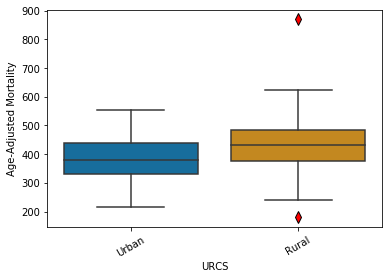

In [21]:
# Run a boxplot of the Urban vs.Rural AAMR

# Set outliers style
flierprops = dict(markerfacecolor='Red', markeredgecolor='black',markersize=8,
              linestyle='none')

# Plot the boxplot
g = sns.boxplot(y='Age-Adjusted Mortality', x='URCS', 
                 data=all_df, 
                 palette="colorblind",flierprops=flierprops)
g.set_xticklabels(g.get_xticklabels(), rotation=30)

We see that there are outliers on the Rural set that need to be removed

[Text(0, 0, 'Large central metro'),
 Text(0, 0, 'Large fringe metro'),
 Text(0, 0, 'Medium metro'),
 Text(0, 0, 'Small metro'),
 Text(0, 0, 'Micropolitan'),
 Text(0, 0, 'Noncore')]

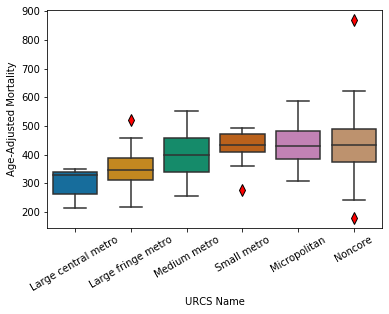

In [22]:
g = sns.boxplot(y='Age-Adjusted Mortality', x='URCS Name', 
                 data=all_df, 
                 palette="colorblind",flierprops=flierprops)
g.set_xticklabels(g.get_xticklabels(), rotation=30)

The URCS boxplot also reveals outliers that need to be removed from the Large fringe metro, Small metro and Noncore datasets

## Clean each column of the dataframe for outliers in each column

For each URCS Name we will make a dataframe from either the urban_df or rural_df as a begining and then act on each column to substitute a NaN value for the outlier.
The cutoff for outliers will be set to a zscore of greater than 2 (So we keep the actual value where zscore < 2 in our mask)

### Create rural and urban dataframes for a starting point to cut on URCS Name indexes

In [23]:
#Create a slice of the multiindex dataframe for Rural
rural_df = multi_df.loc['Rural']

# Check the shape of the initial dataframe for number of rows and columns
print(rural_df.shape)

(172, 158)


We are starting with 172 rows and 158 columns

In [24]:
#Create a slice of the multiindex dataframe for Urban
urban_df = multi_df.loc['Urban']

# Check the shape of the initial dataframe for number of rows and columns
print(urban_df.shape)

(82, 158)


We are starting with 82 rows and 158 columns

# Make a dataframe for each URCS Name and remove outliers

Outliers are outside of two standard deviations from the mean or a |Z-score| < 2

In [25]:
# First cut the urban_df for the URCS Name value (shown in the box plot above)
lcm_df = urban_df.loc['Large central metro']
# Drop the non-numeric columns (they will throw an error if we try to calculate a zscore)
lcm_df = lcm_df.drop(["URCS description","PCP Ratio","Dentist Ratio",\
               "MHP Ratio","Presence of violation","Other PCP Ratio"], axis=1)
# Fill the NaN values with near zero values - otherwise the zscore mask will replace all values in the column with NaN
lcm_df = lcm_df.fillna(0.000001)
# Apply a condition to every column to replace any value with a zscore < 2 with NaN
lcm_df = lcm_df.where(lcm_df.apply(zscore).lt(2))
# Transform all the zero values back to NaN
lcm_df.replace(0, np.nan, inplace=True)
# Reset the Index to put the indexes back into columns 
lcm_df.reset_index(inplace=True)  

In [26]:
# Repeat procedure for each value of the URCS Name value - see above cell comments for logic
lfm_df = urban_df.loc['Large fringe metro']
lfm_df = lfm_df.drop(["URCS description","PCP Ratio","Dentist Ratio",\
               "MHP Ratio","Presence of violation","Other PCP Ratio"], axis=1)
lfm_df = lfm_df.fillna(0.000001)
lfm_df = lfm_df.where(lfm_df.apply(zscore).lt(2))
lfm_df.replace(0, np.nan, inplace=True)
lfm_df.reset_index(inplace=True) 

In [27]:
# Repeat procedure for each value of the URCS Name value - see above cell comments for logic
mm_df = urban_df.loc['Medium metro']
mm_df = mm_df.drop(["URCS description","PCP Ratio","Dentist Ratio",\
               "MHP Ratio","Presence of violation","Other PCP Ratio"], axis=1)
mm_df = mm_df.fillna(0.000001)
mm_df = mm_df.where(mm_df.apply(zscore).lt(2))
mm_df.replace(0, np.nan, inplace=True)
mm_df.reset_index(inplace=True) 

In [28]:
# Repeat procedure for each value of the URCS Name value - see above cell comments for logic
sm_df = urban_df.loc['Small metro']
#sm_df['Age-Adjusted Mortality']
sm_df = sm_df.drop(["URCS description","PCP Ratio","Dentist Ratio",\
               "MHP Ratio","Presence of violation","Other PCP Ratio"], axis=1)
sm_df =sm_df.fillna(0.000001)
sm_df = sm_df.where(sm_df.apply(zscore).lt(2))
sm_df[sm_df['Age-Adjusted Mortality'] < 300] = np.nan
sm_df.replace(0.000001, np.nan, inplace=True)
sm_df.reset_index(inplace=True) 
#sm_df['Age-Adjusted Mortality']

In [29]:
# Repeat procedure for each value of the URCS Name value - see above cell comments for logic
mp_df = rural_df.loc['Micropolitan']
mp_df = mp_df.drop(["URCS description","PCP Ratio","Dentist Ratio",\
               "MHP Ratio","Presence of violation","Other PCP Ratio"], axis=1)
mp_df = mp_df.fillna(0.000001)
mp_df = mp_df.where(mp_df.apply(zscore).lt(2))
#mp_df = mp_df.where(mp_df.apply(zscore).gt(2))
mp_df.replace(0.000001, np.nan, inplace=True)
mp_df.reset_index(inplace=True)

In [30]:
# Repeat procedure for each value of the URCS Name value - see above cell comments for logic
nc_df = rural_df.loc['Noncore']
nc_df = nc_df.drop(["URCS description","PCP Ratio","Dentist Ratio",\
               "MHP Ratio","Presence of violation","Other PCP Ratio"], axis=1)
nc_df = nc_df.fillna(0.000001)
nc_df = nc_df.where(nc_df.apply(zscore).abs().lt(2))
nc_df[nc_df['Age-Adjusted Mortality'] < 200] = np.nan
nc_df.replace(0.000001, np.nan, inplace=True)
nc_df.reset_index(inplace=True) 
#nc_df['Age-Adjusted Mortality']

### Concatonate the partial dataframes back together into one clean dataframe

In [31]:
# Concatonate all the partial dataframes that have removed outliers relative to their URCS Name classification
clean_df = pd.concat([lcm_df, lfm_df, mm_df, sm_df, mp_df, nc_df])

### Merge the clean dataframe with the original URCS Name data

In [32]:
# Merge the clean dataframe back with the urcs dataframe to add back the URCS columns
all_clean_df = pd.merge(urcs,clean_df, how='inner', on='FIPS')

# Verify we got back the expected number of rows and columns
print(all_clean_df.shape)

(251, 156)


In [33]:
# Set index to a multiindex again using 3 columns
multi_clean_df = all_clean_df.set_index(['URCS','URCS Name','County'])

# Sort the index (otherwise some slicing functions won't work properly - also it drastically improves speed)
multi_clean_df = multi_clean_df.sort_index()
print(multi_clean_df.shape)

(251, 153)


## Regenerate clean urban_df and rural_df from multi_clean_df

In [34]:
rural_clean_df = multi_clean_df.loc['Rural']
print(rural_df.shape)

(172, 158)


In [35]:
urban_clean_df = multi_clean_df.loc['Urban']
print(urban_df.shape)

(82, 158)


### Make a clean dataframe (no outliers) for each type of URCS Name

In [36]:
lcm_clean_df = urban_clean_df.loc['Large central metro']
lfm_clean_df = urban_clean_df.loc['Large fringe metro']
mm_clean_df = urban_clean_df.loc['Medium metro']
sm_clean_df = urban_clean_df.loc['Small metro']
mp_clean_df = rural_clean_df.loc['Micropolitan']
nc_clean_df = rural_clean_df.loc['Noncore']

## Rerun Box plot to verify no outliers for our dependent variable 'Age-Adjusted Mortality'

[Text(0, 0, 'Urban'), Text(0, 0, 'Rural')]

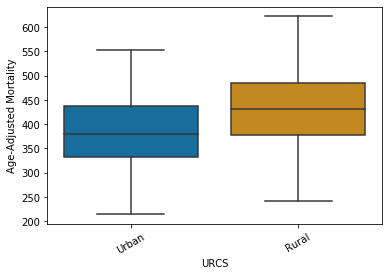

In [37]:
# Run a boxplot of the Urban vs.Rural AAMR using clean dataframe

# Set outliers style
flierprops = dict(markerfacecolor='Red', markeredgecolor='black',markersize=8,
              linestyle='none')

# Plot the boxplot
g = sns.boxplot(y='Age-Adjusted Mortality', x='URCS', 
                 data=all_clean_df, 
                 palette="colorblind",flierprops=flierprops)
g.set_xticklabels(g.get_xticklabels(), rotation=30)

We don't see any outliers on the Urban and Rural dataframes

[Text(0, 0, 'Large central metro'),
 Text(0, 0, 'Large fringe metro'),
 Text(0, 0, 'Medium metro'),
 Text(0, 0, 'Small metro'),
 Text(0, 0, 'Micropolitan'),
 Text(0, 0, 'Noncore')]

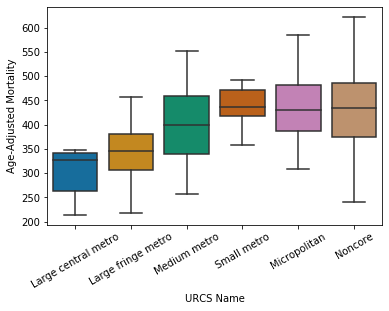

In [38]:
# Plot the URCS Name categories and check that outliers have been removed
g = sns.boxplot(y='Age-Adjusted Mortality', x='URCS Name', 
                 data=all_clean_df, 
                 palette="colorblind",flierprops=flierprops)
g.set_xticklabels(g.get_xticklabels(), rotation=30)

The URCS boxplot shows no outliers

# Is there a significant difference between Urban and Rural populations?


## Function to create a pair of t-test plots

In [39]:
# Generate a t-test plot pair
def ttestplot(pop1, pop2):
    # Scatter Plot of Data
    plt.subplot(2, 1, 1)
    plt.scatter(range(len(pop1)), pop1, label="pop1")
    plt.scatter(range(len(pop2)), pop2, label="pop2")
    plt.legend()

    # Histogram Plot of Data
    plt.subplot(2, 1, 2)
    plt.hist(pop1, 10, density=True, alpha=0.7, label="pop1")
    plt.hist(pop2, 10, density=True, alpha=0.7, label="pop2")
    plt.axvline(pop1.mean(), color='k', linestyle='dashed', linewidth=1)
    plt.axvline(pop2.mean(), color='k', linestyle='dashed', linewidth=1)
    plt.legend()  

In [40]:
# Create a series of just the Urban,AAMR data and also Rural,AAMR
urban_aamr = multi_clean_df.loc['Urban','Age-Adjusted Mortality'].dropna()
rural_aamr = multi_clean_df.loc['Rural','Age-Adjusted Mortality'].dropna()

### Run t-test on the Urban and Rural AAMR populations

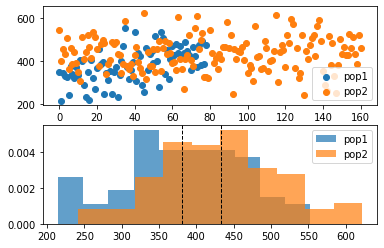

In [41]:
ttestplot(urban_aamr,rural_aamr)

In [42]:
# Run a t-test between the urban and rural Age-Adjusted Mortality
stats.ttest_ind(urban_aamr, rural_aamr, equal_var=False)

Ttest_indResult(statistic=-4.731900084902864, pvalue=5.013491835981784e-06)

#### The pvalue of 5.01x10e-6 is much smaller than 0.05 so there is a strong statistically significant difference between Urban and Rural populations with respect to measuring AAMR 

If we segment our Urban and Rural populations using the URCS Classification scheme will we see a difference among the subpopulations of Urban and Rural?

## URCS Name Categories for t-test

In [43]:
# Create a series of just the Urban,AAMR data and also Rural,AAMR for each group
lcm_aamr = urban_clean_df.loc['Large central metro','Age-Adjusted Mortality'].dropna()
lfm_aamr = urban_clean_df.loc['Large fringe metro','Age-Adjusted Mortality'].dropna()
mm_aamr = urban_clean_df.loc['Medium metro','Age-Adjusted Mortality'].dropna()
sm_aamr = urban_clean_df.loc['Small metro','Age-Adjusted Mortality'].dropna()
mp_aamr = rural_clean_df.loc['Micropolitan','Age-Adjusted Mortality'].dropna()
nc_aamr = rural_clean_df.loc['Noncore','Age-Adjusted Mortality'].dropna()

### Test 'Large central metro' (lcm) area against  'Micropolitan' (mp) rural areas using a t-test

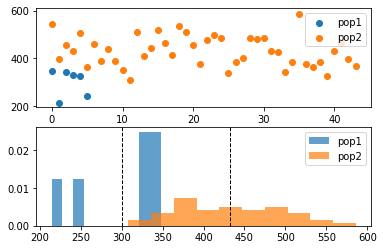

In [44]:
ttestplot(lcm_aamr,mp_aamr)

In [45]:
# Run a t-test between the urban lcm and rural mp for Age-Adjusted Mortality
stats.ttest_ind(lcm_aamr, mp_aamr, equal_var=False)

Ttest_indResult(statistic=-5.17916727114997, pvalue=0.0013662029029729151)

#### The pvalue of 0.0013 is much smaller than 0.05 so there is a statistically significant difference between Large central metro and Micropolitan populations with respect to measuring AAMR - however the small sample size is cause for concern.

### Test 'Large central metro' (lcm) area against  'Noncore' (nc) rural areas using a t-test

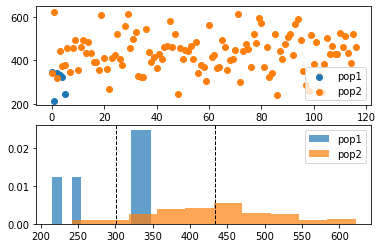

In [46]:
ttestplot(lcm_aamr,nc_aamr)

In [47]:
# Run a t-test between the urban lcm and rural nc for Age-Adjusted Mortality
stats.ttest_ind(lcm_aamr, nc_aamr, equal_var=False)

Ttest_indResult(statistic=-5.360783209206877, pvalue=0.0015806648534332046)

#### The pvalue of 0.0016 is much smaller than 0.05 so there is a statistically significant difference between Large central metro and Noncore populations with respect to measuring AAMR - however the small sample size is cause for concern.

### Test 'Large central metro' (lcm) area against  'Large fringe metro' (lfm) urban areas using a t-test

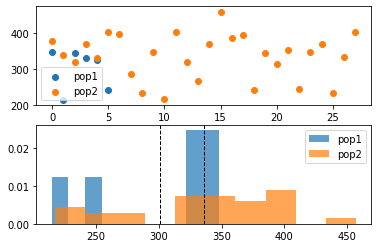

In [48]:
ttestplot(lcm_aamr,lfm_aamr)

In [49]:
# Run a t-test between the urban lcm and urban lfm for Age-Adjusted Mortality
stats.ttest_ind(lcm_aamr, lfm_aamr, equal_var=False)

Ttest_indResult(statistic=-1.3423352117863, pvalue=0.21749505027772037)

#### The pvalue of 0.2175 is much greater than 0.05 so there is no statistically significant difference between Large central metro and Large fringe metro urban populations with respect to measuring AAMR - however the small sample size is cause for concern.

### Test 'Large central metro' (lcm) area against  'Medium metro' (mm) urban areas using a t-test

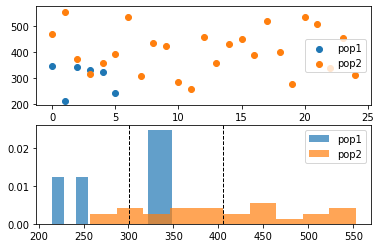

In [50]:
ttestplot(lcm_aamr,mm_aamr)

In [51]:
# Run a t-test between the urban lcm and urban mm for Age-Adjusted Mortality
stats.ttest_ind(lcm_aamr, mm_aamr, equal_var=False)

Ttest_indResult(statistic=-3.6000176726999022, pvalue=0.004034765207805986)

#### The pvalue of 0.0040 is much smaller than 0.05 so there is a statistically significant difference between Large central metro and Medium metro urban populations with respect to measuring AAMR - however the small sample size is cause for concern.,  and 'Small metro' (sm) 

### Test 'Large central metro' (lcm) area against  Small metro' (sm) urban areas using a t-test

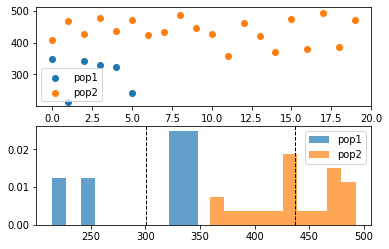

In [52]:
ttestplot(lcm_aamr,sm_aamr)### Test 'Large central metro' (lcm) area against  'Small metro' (sm) urban areas using a t-test

In [53]:
# Run a t-test between the urban lcm and urban sm for Age-Adjusted Mortality
stats.ttest_ind(lcm_aamr, sm_aamr, equal_var=False)

Ttest_indResult(statistic=-5.418686036720096, pvalue=0.0012260087702403997)

#### The pvalue of 0.0012 is much smaller than 0.05 so there is a statistically significant difference between Large central metro and Small metro urban populations with respect to measuring AAMR - however the small sample size is cause for concern.

## The lcm urban area has a significantly better health outcomes against every urban area (except Large fringe metro) 
The pvalues of 0.0040 and 0.0012 show a statistically significant better outcome for lcm vs. both mm and sm but
the pvalue of 0.2175 does not show a statistically significant difference in health outcome as measured by AAMR

### Test 'Large fringe metro' (lfm) area against  'Micropolitan' (mp)  rural area using a t-test

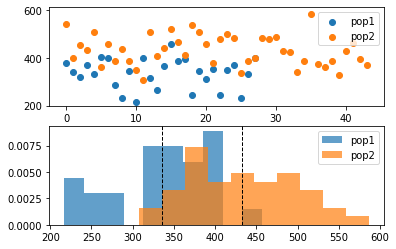

In [54]:
ttestplot(lfm_aamr,mp_aamr)

In [55]:
# Run a t-test between the urban lfm and rural mp for Age-Adjusted Mortality
stats.ttest_ind(lfm_aamr, mp_aamr, equal_var=False)

Ttest_indResult(statistic=-6.299666267651455, pvalue=4.025405061713767e-08)

#### The pvalue of 4.03x10e-8 is much smaller than 0.05 so there is a statistically significant difference between Large fringe metro and Micropolitan urban populations with respect to measuring AAMR 

### Test 'Large fringe metro' (lfm) area against 'Noncore' (nc) rural area using a t-test

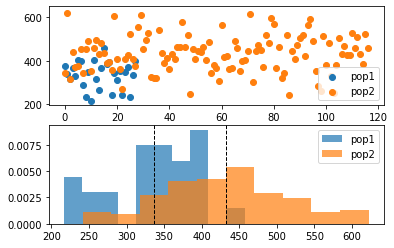

In [56]:
ttestplot(lfm_aamr,nc_aamr)

In [57]:
# Run a t-test between the urban lfm and rural nc for Age-Adjusted Mortality
stats.ttest_ind(lfm_aamr, nc_aamr, equal_var=False)

Ttest_indResult(statistic=-6.884982635586501, pvalue=6.538130703639622e-09)

#### The pvalue of 6.54x10e-9 is much smaller than 0.05 so there is a statistically significant difference between Large fringe metro and Micropolitan urban populations with respect to measuring AAMR

## The lfm urban area has strongly significantly better health outcome against both rural areas mp and nc
The pvalues of 4.03x10e-8 and 6.54x10e-9 do show a strong statistically significant better outcome for lfm vs. both mp and nc

### Test 'Medium metro' (mm) area against the 'Micropolitan' (mp) rural area using a t-test

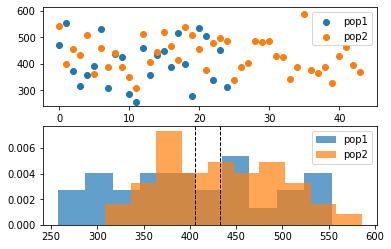

In [58]:
ttestplot(mm_aamr,mp_aamr)

In [59]:
# Run a t-test between the urban lcm and urban lfm for Age-Adjusted Mortality
stats.ttest_ind(mm_aamr, mp_aamr, equal_var=False)

Ttest_indResult(statistic=-1.3403025174765106, pvalue=0.18781289769440798)

#### The pvalue of 0.1878 is much greater than 0.05 so there is no statistically significant difference between Medium metro and Micropolitan rural populations with respect to measuring AAMR 

### Test 'Medium metro' (lcm) area against  'Noncore' (nc) rural areas using a t-test

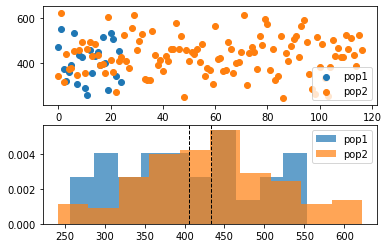

In [60]:
ttestplot(mm_aamr,nc_aamr)

In [61]:
# Run a t-test between the urban lcm and rural nc for Age-Adjusted Mortality
stats.ttest_ind(mm_aamr, nc_aamr, equal_var=False)

Ttest_indResult(statistic=-1.4529513646191967, pvalue=0.15527453172223435)

#### The pvalue of 0.1553 is much greater than 0.05 so there is not a statistically significant difference between Medium metro and Noncore populations with respect to measuring AAMR

### Test 'Medium metro' (mm) area against  'Small metro' (sm) urban areas using a t-test

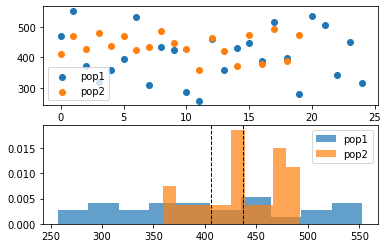

In [62]:
ttestplot(mm_aamr,sm_aamr)

In [63]:
# Run a t-test between the urban lcm and rural mp for Age-Adjusted Mortality
stats.ttest_ind(mm_aamr,sm_aamr, equal_var=False)

Ttest_indResult(statistic=-1.6009721702895792, pvalue=0.11823739667750645)

#### The pvalue of 0.1182 is greater than 0.05 so there is not a statistically significant difference between Medium metro and Small metro populations with respect to measuring AAMR

## The Medium metro urban area has no statistically significant better health outcome against both rural areas mp and nc or the urban Small metro areas
The pvalues of 0.1878 (mp), 0.1553 (nc) and 0.1182 (sm) show that the Medium metro urban area does not show a statistically significant better health outcome as measured by AAMR

# Examine the Top 5 "Best" and "Worst" counties 

In [64]:
# Sort and choose the smallest AAMR counties
# Recall that Age-Adjusted Mortality Rate is (100s of death per 100,000 population) so a lower number is a better outcome
top_df = all_clean_df.nsmallest(5, ['Age-Adjusted Mortality'])
top_1df = top_df[["URCS","URCS Name", "County","Age-Adjusted Mortality"]]
print('The top five counties for best health outcome in Texas: ')
top_1df

The top five counties for best health outcome in Texas: 


,URCS,URCS Name,County,Age-Adjusted Mortality
1,Urban,Large central metro,Collin,214.4
16,Urban,Large fringe metro,Fort Bend,216.9
14,Urban,Large fringe metro,Denton,233.3
32,Urban,Large fringe metro,Williamson,233.5
217,Rural,Noncore,Presidio,241.4


In [65]:
# Sort and choose the largest AAMR counties
# Recall that Age-Adjusted Mortality Rate is (100s of death per 100,000 population) so a lower number is a better outcome
bottom_df = all_clean_df.nlargest(5, ['Age-Adjusted Mortality'])
bottom_1df = bottom_df[["URCS","URCS Name", "County", "Age-Adjusted Mortality"]]
print('The top five counties: ')
bottom_1df

The top five counties: 


,URCS,URCS Name,County,Age-Adjusted Mortality
127,Rural,Noncore,Baylor,622.3
201,Rural,Noncore,Marion,613.6
156,Rural,Noncore,Duval,611.6
146,Rural,Noncore,Cottle,606.9
210,Rural,Noncore,Morris,596.0


# What factors correlate with AAMR?

We will run a Pearson's correlation matrix to examine each factor against every other factor

In [66]:
corr1 = multi_clean_df.corr()

In [67]:
# Save the corr1 csv file
corr1.to_csv('output/Corr1.csv')

In [68]:
multi_clean_df.to_csv('output/multi_clean_df.csv')

In [69]:
# We also ran a Spearman correlation matrix to see if any non-linear correlations would make a difference - it didn't
corr1_spear = multi_clean_df.corr(method='spearman')

In [70]:
# Save the corr1_spear csv file
corr1_spear.to_csv('output/Corr1_spear.csv')

# Results of Pearson Correlation matrix

# Excel condition formatted Pearson Correlation matrix

The excel file was necessary because we wanted to pick the best dependent variable and also exclude the other dependent variables that were also essentially measuring death rates in different ways. We did not know of any statistical test that could do that. Finally, we found it much easier to sort a conditionally formatted table to zero in on ~10 positively correlated factors and ~10 negatively correlated factors relative to Age-Adjusted Mortality Rate (AAMR)
![ExcelCorrMatrixAll](Images/excel_corr_matrix.png)
[Excel Correlation File](output/corr1.xlsx)

Text(0.5, 1, 'Pearson Correlation matrix for all correlated variables')

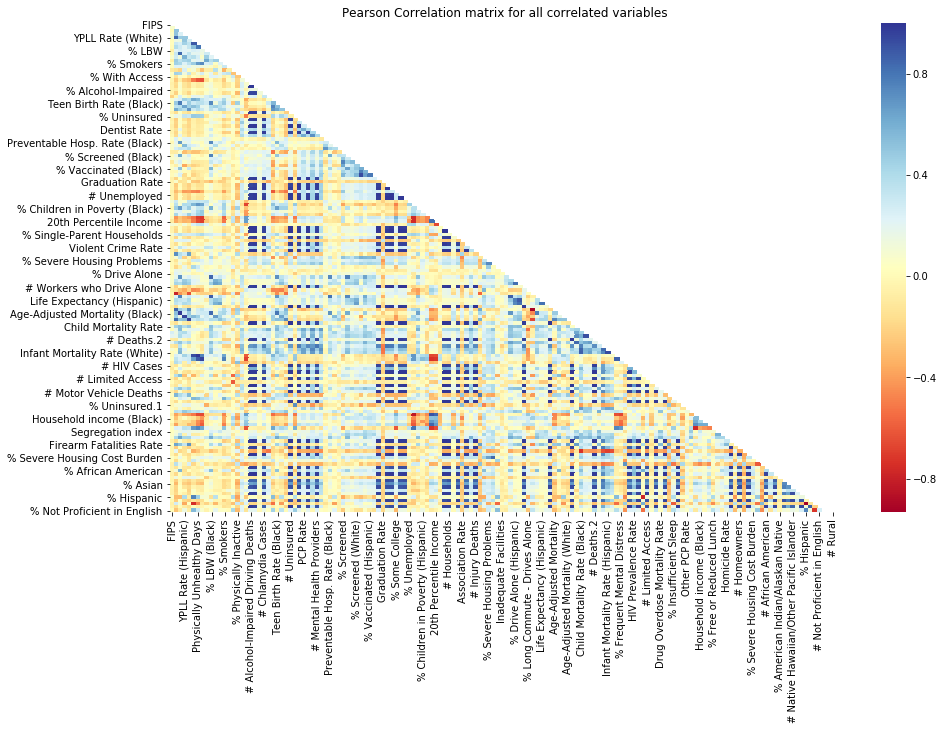

In [71]:
# Plot the Pearson Correlation reduced matrix
matrix = np.triu(corr1)
fig, ax = plt.subplots(figsize=(15,9)) 
ax = sns.heatmap(corr1,   mask = matrix, cmap = 'RdYlBu')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Pearson Correlation matrix for all correlated variables')

In [72]:
# Create a list of columns chosen using Excel corr matrix 
cols = ["Age-Adjusted Mortality","Teen Birth Rate (White)","Teen Birth Rate (Black)",
"% Physically Inactive","% Diabetic","% Children in Poverty (Black)","% Food Insecure",
"% Smokers","% Children in Poverty","% Disconnected Youth","Teen Birth Rate (Hispanic)",
"Teen Birth Rate","Household income (Hispanic)","% With Access","PCP Rate","Cohort Size",
"Food Environment Index","20th Percentile Income","80th Percentile Income","Household Income",
"Household income (White)","Household income (Black)"]

# Copy the dataframe slice into ndf variable
ndf = all_clean_df[cols].copy()

# Run the Pearson's correlation matrix
corr1 = ndf.corr()

Text(0.5, 1, 'Pearson Correlation matrix for Top 20 most correlated variables')

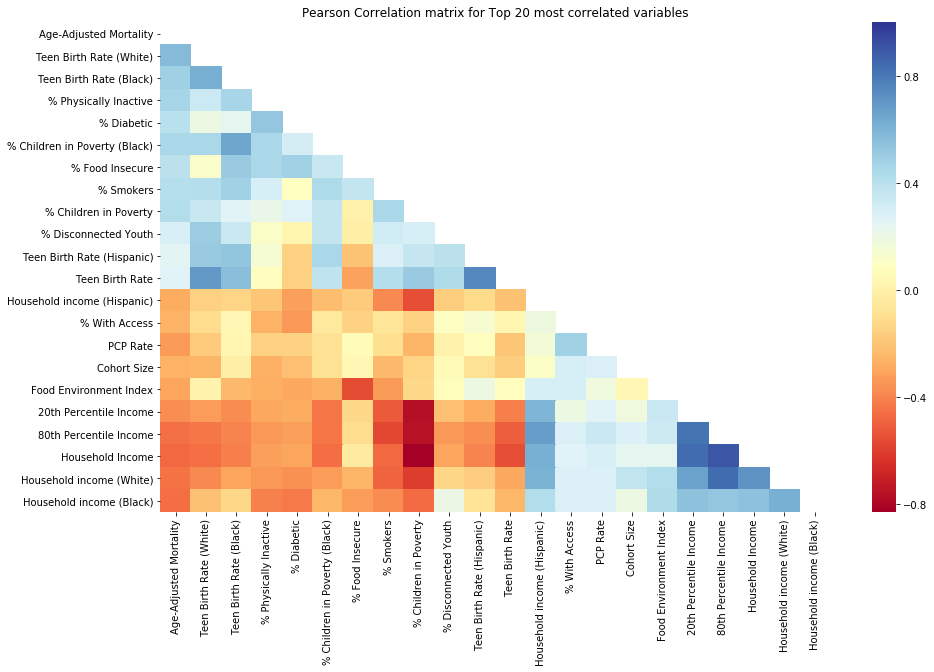

In [73]:
# Plot the Pearson Correlation reduced matrix
matrix = np.triu(corr1)
fig, ax = plt.subplots(figsize=(15,9)) 
ax = sns.heatmap(corr1,   mask = matrix, cmap = 'RdYlBu')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Pearson Correlation matrix for Top 20 most correlated variables')

# Examine the different parameters by plotting scatterplots

We will examine the scatterplots and for what we deem interesting we will conduct a deeper analysis using Regression analysis

### Function to easily do a panel of scatterplots easily

In [74]:
def makePanelScatterplot(data_df, x_data,y_data,color_col,split_col):
    x_label = x_data
    y_label = y_data
    ylim_min = data_df[y_data].min()*1.05
    ylim_max = data_df[y_data].max()*1.05
    xlim_min = data_df[x_data].min()*1.05
    xlim_max = data_df[x_data].max()*1.05

    g = sns.lmplot(x=x_data, y=y_data, data=data_df,\
           hue=color_col, col=split_col,col_wrap=3)

        
    g = (g.set_axis_labels(x_label, y_label)
          .set(ylim=(ylim_min, ylim_max),xlim=(xlim_min, xlim_max))
          .fig.subplots_adjust(wspace=.02))

### Function to call OLS Regression Statsmodel from 2 columns of dataframe

In [75]:
def olsRegressionAnalysis (df,df_name,dep_col,ind_col):
    stat_dep_col = dep_col.replace(' ','_').replace('-','_').replace('(','_').replace(')','')
    stat_ind_col = ind_col.replace(' ','_').replace('-','_').replace('(','_').replace(')','')
    stat_col_list = [stat_dep_col,stat_ind_col]
    #print(f'stat_dep_col: {stat_dep_col}, stat_ind_col: {stat_ind_col}')
    col_list = [dep_col,ind_col]

    col_dict = {col_list[i]: stat_col_list[i] for i in range(len(col_list))} 
    #print(col_dict)
    stat_df = df[col_list].dropna()
    stat_df.rename(columns=col_dict,inplace=True)
    print(f'\u001b[34m{dep_col}\u001b[0m fitted against \u001b[34m{ind_col}\u001b[0m \
    using \x1b[31m{df_name}\x1b[0m dataframe:\n')
    print(f'We have {stat_df.shape[0]} rows left after dropping Null values\n')
    model_string = stat_dep_col + " ~ " + stat_ind_col
    all_model = ols(model_string, data=stat_df).fit()
    print(all_model.summary())

# Plot scatterplots and after examination choose some of them to do Regression analysis

## Age adjusted Mortality (Deaths/100k) vs. Household Income for Everyone

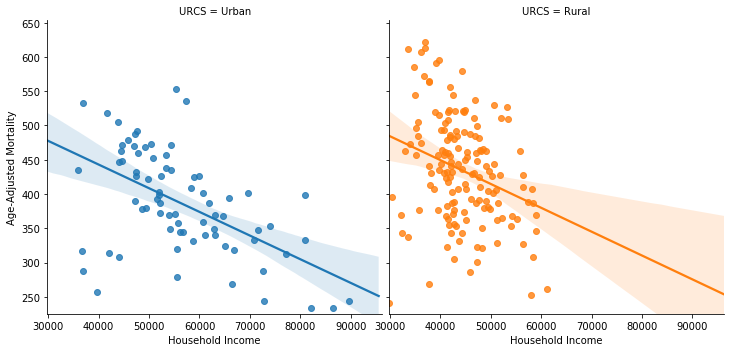

In [76]:
makePanelScatterplot(all_clean_df,"Household Income","Age-Adjusted Mortality","URCS","URCS")

## Statistically Examine the Urban AAMR vs.Household Income (HI)

 First run a regression analysis using the ols and statsmodel packages
 We are interested in the R-squared value F-statistic and the pvalue (P>|t|) for the t-test of the independent variable against the dependent variable ( pvalue < 0.05 is good )

In [77]:
olsRegressionAnalysis(urban_clean_df,"urban_clean_df","Age-Adjusted Mortality","Household Income")

Age-Adjusted Mortality fitted against Household Income     using urban_clean_df dataframe:

We have 76 rows left after dropping Null values

                              OLS Regression Results                              
Dep. Variable:     Age_Adjusted_Mortality   R-squared:                       0.314
Model:                                OLS   Adj. R-squared:                  0.305
Method:                     Least Squares   F-statistic:                     33.92
Date:                    Sat, 01 Feb 2020   Prob (F-statistic):           1.39e-07
Time:                            09:24:03   Log-Likelihood:                -423.90
No. Observations:                      76   AIC:                             851.8
Df Residuals:                          74   BIC:                             856.5
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                       coef  

### The R-squared value for Urban AAMR vs. HI is 0.314 which shows an ok linear regression relationship
The pvalue for the t-test of Household Income vs. AAMR shows that we can reject the null-hypothesis that the coefficient of the Household Income variable is zero - meaning there is a relationship between the two variables

In [78]:
olsRegressionAnalysis(rural_clean_df,"rural_clean_df","Age-Adjusted Mortality","Household Income")

Age-Adjusted Mortality fitted against Household Income     using rural_clean_df dataframe:

We have 156 rows left after dropping Null values

                              OLS Regression Results                              
Dep. Variable:     Age_Adjusted_Mortality   R-squared:                       0.088
Model:                                OLS   Adj. R-squared:                  0.082
Method:                     Least Squares   F-statistic:                     14.86
Date:                    Sat, 01 Feb 2020   Prob (F-statistic):           0.000170
Time:                            09:24:03   Log-Likelihood:                -894.06
No. Observations:                     156   AIC:                             1792.
Df Residuals:                         154   BIC:                             1798.
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                       coef 

### The R-Squared value for Rural  AAMR vs. HI is 0.088 which shows relatively no relationship 
The pvalue for the t-test of Household Income vs. AAMR shows that we can reject the null-hypothesis that the coefficient of the Household Income variable is zero - meaning there is a relationship between the two variables ablbeit a very weak one based on the R-Squared value

## What if we examine this relationship segmented by the URCS?

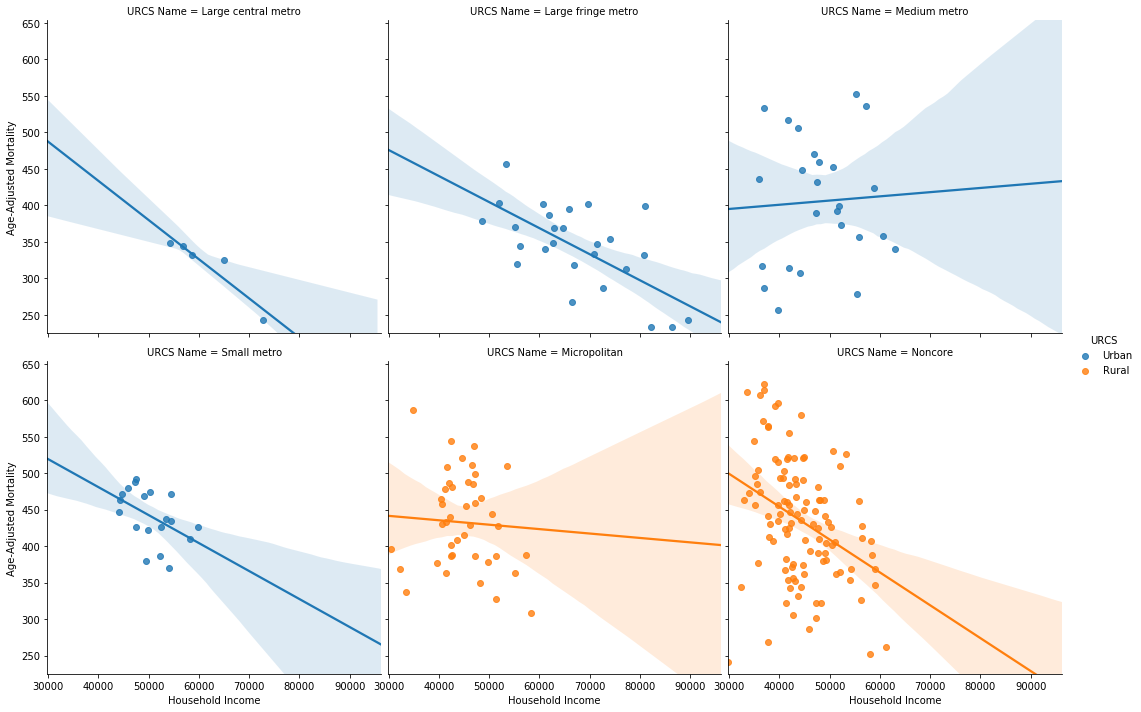

In [79]:
makePanelScatterplot(all_clean_df,"Household Income","Age-Adjusted Mortality","URCS","URCS Name")

Most of these are obviously NOT correlated linearly upon visual inspection - so we will only test two

## Statistically Examine the Urban Large central metro & Large fringe metro AAMR vs.Household Income (HI)

 First run a regression analysis using the ols and statsmodel packages
 We are interested in the R-squared value F-statistic and the pvalue (P>|t|) for the t-test of the independent variable against the dependent variable ( pvalue < 0.05 is good )

In [80]:
olsRegressionAnalysis(lcm_clean_df,"lcm_clean_df","Age-Adjusted Mortality","Household Income")

Age-Adjusted Mortality fitted against Household Income     using lcm_clean_df dataframe:

We have 5 rows left after dropping Null values

                              OLS Regression Results                              
Dep. Variable:     Age_Adjusted_Mortality   R-squared:                       0.872
Model:                                OLS   Adj. R-squared:                  0.829
Method:                     Least Squares   F-statistic:                     20.43
Date:                    Sat, 01 Feb 2020   Prob (F-statistic):             0.0202
Time:                            09:24:06   Log-Likelihood:                -20.209
No. Observations:                       5   AIC:                             44.42
Df Residuals:                           3   BIC:                             43.64
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                       coef    s

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\stats\stattools.py:71: ValueWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  "samples were given." % int(n), ValueWarning)


### The R-squared value for Urban Large central metro AAMR vs. HI is 0.872 which shows an great linear regression relationship - however the small sample size of n = 5 renders this result dubious
The pvalue for the t-test of Household Income vs. AAMR of 0.02 shows that we can reject the null-hypothesis that the coefficient of the Household Income variable is zero - meaning there is a relationship between the two variables

In [81]:
olsRegressionAnalysis(lfm_clean_df,"lfm_clean_df","Age-Adjusted Mortality","Household Income")

Age-Adjusted Mortality fitted against Household Income     using lfm_clean_df dataframe:

We have 27 rows left after dropping Null values

                              OLS Regression Results                              
Dep. Variable:     Age_Adjusted_Mortality   R-squared:                       0.478
Model:                                OLS   Adj. R-squared:                  0.457
Method:                     Least Squares   F-statistic:                     22.89
Date:                    Sat, 01 Feb 2020   Prob (F-statistic):           6.52e-05
Time:                            09:24:06   Log-Likelihood:                -139.83
No. Observations:                      27   AIC:                             283.7
Df Residuals:                          25   BIC:                             286.2
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                       coef    

### The R-squared value for Urban Large fringe metro AAMR vs. HI is 0.478 which shows an good linear regression relationship
The pvalue for the t-test of Household Income vs. AAMR of 0.00 shows that we can reject the null-hypothesis that the coefficient of the Household Income variable is zero - meaning there is a relationship between the two variables

# Does Race play a role in the relationship between AAMR & Household Income?

# Age adjusted Mortality (Deaths/100k) for Blacks

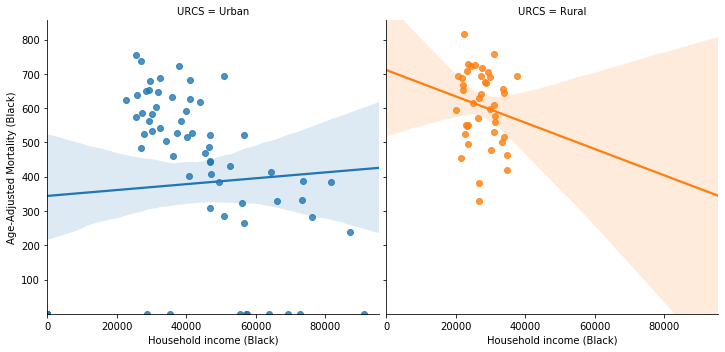

In [82]:
makePanelScatterplot(all_clean_df,"Household income (Black)","Age-Adjusted Mortality (Black)","URCS","URCS")

## Statistically Examine the Urban AAMR vs.Household Income (HI) for Blacks

 First run a regression analysis using the ols and statsmodel packages
 We are interested in the R-squared value F-statistic and the pvalue (P>|t|) for the t-test of the independent variable against the dependent variable ( pvalue < 0.05 is good )

In [83]:
olsRegressionAnalysis(urban_clean_df,"urban_clean_df","Age-Adjusted Mortality","Household income (Black)")

Age-Adjusted Mortality fitted against Household income (Black)     using urban_clean_df dataframe:

We have 73 rows left after dropping Null values

                              OLS Regression Results                              
Dep. Variable:     Age_Adjusted_Mortality   R-squared:                       0.204
Model:                                OLS   Adj. R-squared:                  0.193
Method:                     Least Squares   F-statistic:                     18.18
Date:                    Sat, 01 Feb 2020   Prob (F-statistic):           6.10e-05
Time:                            09:24:06   Log-Likelihood:                -414.81
No. Observations:                      73   AIC:                             833.6
Df Residuals:                          71   BIC:                             838.2
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                     

### The R-squared value for Urban AAMR vs. HI is 0.532 which shows an good linear regression relationship
The pvalue for the t-test of Household Income vs. AAMR (pvalue =0)shows that we can reject the null-hypothesis that the coefficient of the Household Income variable is zero - meaning there is a relationship between the two variables

In [84]:
olsRegressionAnalysis(rural_clean_df,"rural_clean_df","Age-Adjusted Mortality","Household income (Black)")

Age-Adjusted Mortality fitted against Household income (Black)     using rural_clean_df dataframe:

We have 84 rows left after dropping Null values

                              OLS Regression Results                              
Dep. Variable:     Age_Adjusted_Mortality   R-squared:                       0.089
Model:                                OLS   Adj. R-squared:                  0.077
Method:                     Least Squares   F-statistic:                     7.963
Date:                    Sat, 01 Feb 2020   Prob (F-statistic):            0.00599
Time:                            09:24:06   Log-Likelihood:                -470.11
No. Observations:                      84   AIC:                             944.2
Df Residuals:                          82   BIC:                             949.1
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                     

### The R-Squared value for Rural  AAMR vs. HI is 0.089 which shows relatively no relationship 
The pvalue for the t-test of Household Income vs. AAMR shows that we cannot reject the null-hypothesis that the coefficient of the Household Income variable is zero - meaning there is a relationship between the two variables ablbeit a very weak one based on the R-Squared value

## What if we examine this relationship segmented by the URCS?

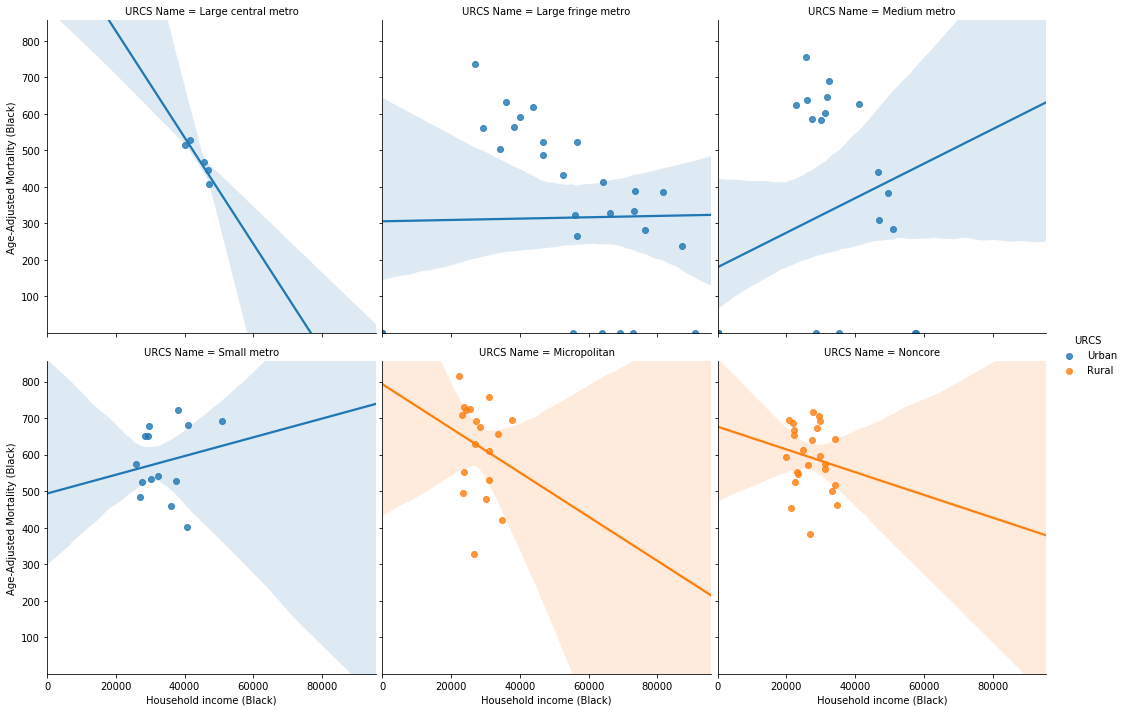

In [85]:
makePanelScatterplot(all_clean_df,"Household income (Black)","Age-Adjusted Mortality (Black)","URCS","URCS Name")

The Large central metro looks like a strong correlation, but there are too few points to get any meaningful data so we will not examine that one. The large fringe and Medium metro urban areas look like good candidates. Finally the Small metro, Micropolitan and Noncore areas do not appear to be correlated so we will skip those.

## Statistically Examine the Large fringe metro Urban AAMR vs.Household Income (HI) for Blacks

In [86]:
olsRegressionAnalysis(lfm_clean_df,"lfm_clean_df","Age-Adjusted Mortality","Household income (Black)")

Age-Adjusted Mortality fitted against Household income (Black)     using lfm_clean_df dataframe:

We have 28 rows left after dropping Null values

                              OLS Regression Results                              
Dep. Variable:     Age_Adjusted_Mortality   R-squared:                       0.188
Model:                                OLS   Adj. R-squared:                  0.157
Method:                     Least Squares   F-statistic:                     6.033
Date:                    Sat, 01 Feb 2020   Prob (F-statistic):             0.0210
Time:                            09:24:08   Log-Likelihood:                -151.90
No. Observations:                      28   AIC:                             307.8
Df Residuals:                          26   BIC:                             310.5
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                       

### The R-squared value for Urban AAMR vs. HI is 0.388 which shows an good linear regression relationship
The pvalue for the t-test of Household Income vs. AAMR (pvalue =0.001 )shows that we can reject the null-hypothesis that the coefficient of the Household Income variable is zero - meaning there is a relationship between the two variables

In [87]:
olsRegressionAnalysis(mm_clean_df,"mm_clean_df","Age-Adjusted Mortality","Household income (Black)")

Age-Adjusted Mortality fitted against Household income (Black)     using mm_clean_df dataframe:

We have 23 rows left after dropping Null values

                              OLS Regression Results                              
Dep. Variable:     Age_Adjusted_Mortality   R-squared:                       0.040
Model:                                OLS   Adj. R-squared:                 -0.006
Method:                     Least Squares   F-statistic:                    0.8637
Date:                    Sat, 01 Feb 2020   Prob (F-statistic):              0.363
Time:                            09:24:08   Log-Likelihood:                -134.41
No. Observations:                      23   AIC:                             272.8
Df Residuals:                          21   BIC:                             275.1
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                        

### The R-Squared value for Rural  AAMR vs. HI is 0.621 which shows strong relationship 
The pvalue for the t-test of Household Income vs. AAMR (pvalue = 0) shows that we cannot reject the null-hypothesis that the coefficient of the Household Income variable is zero - meaning there is a relationship between the two variables - although we have a warning due to the low n of 17 with only 15 residuals.

## The conclusion is that income correlates with Age-Adjusted Mortality Rate. But what appears to be the case is that as you move out of the city people make less than a certain amount of money on average. Making more money is what seems to be what is improving health outcomes, specifically making more than around \\\$60,000

# Age adjusted Mortality (Deaths/100k) for Whites

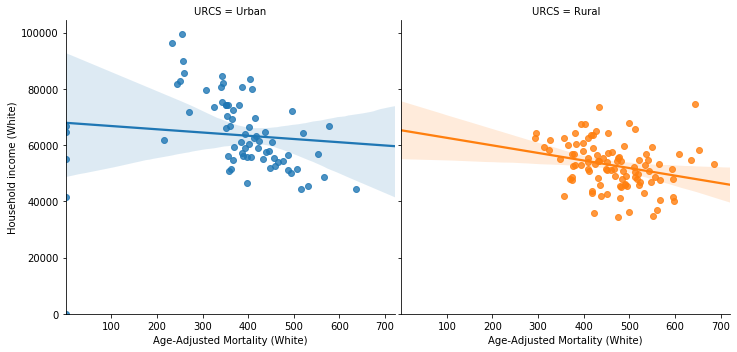

In [88]:
makePanelScatterplot(all_clean_df,"Age-Adjusted Mortality (White)","Household income (White)","URCS","URCS")

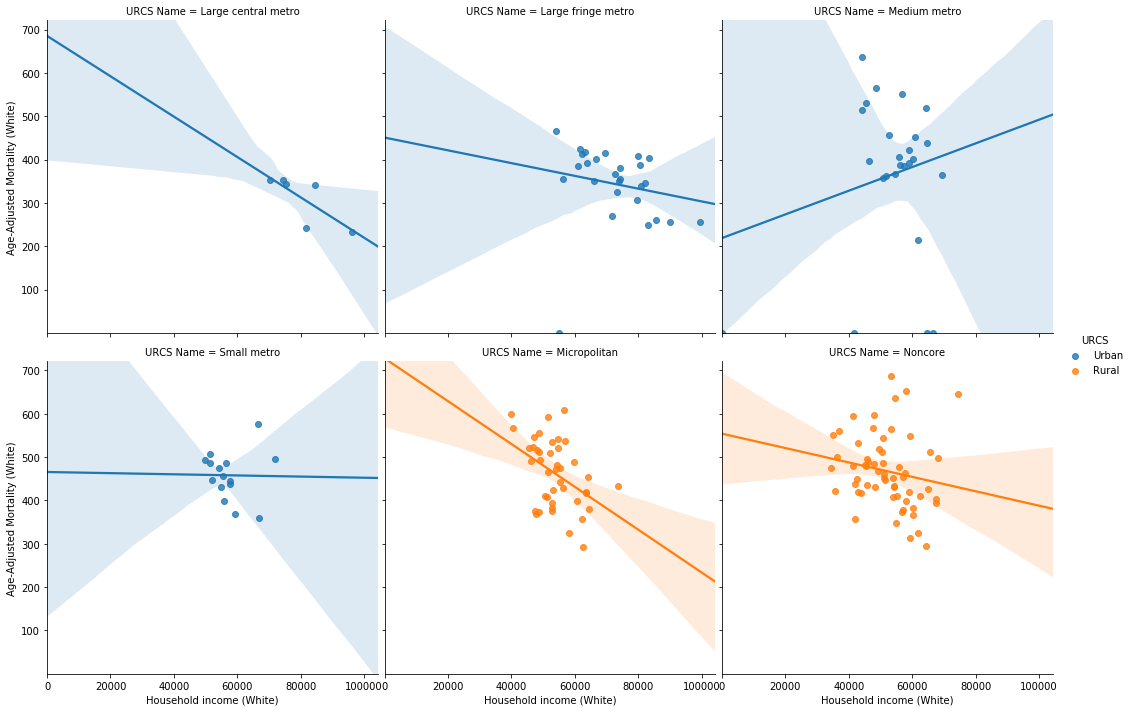

In [89]:
makePanelScatterplot(all_clean_df,"Household income (White)","Age-Adjusted Mortality (White)","URCS","URCS Name")

# Age adjusted Mortality (Deaths/100k) for Hispanics

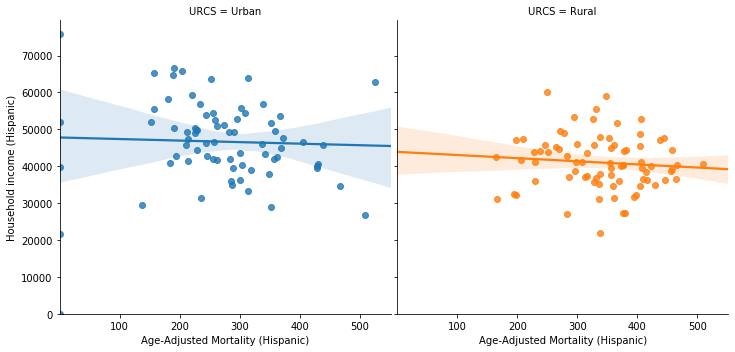

In [90]:
makePanelScatterplot(all_clean_df,"Age-Adjusted Mortality (Hispanic)","Household income (Hispanic)","URCS","URCS")

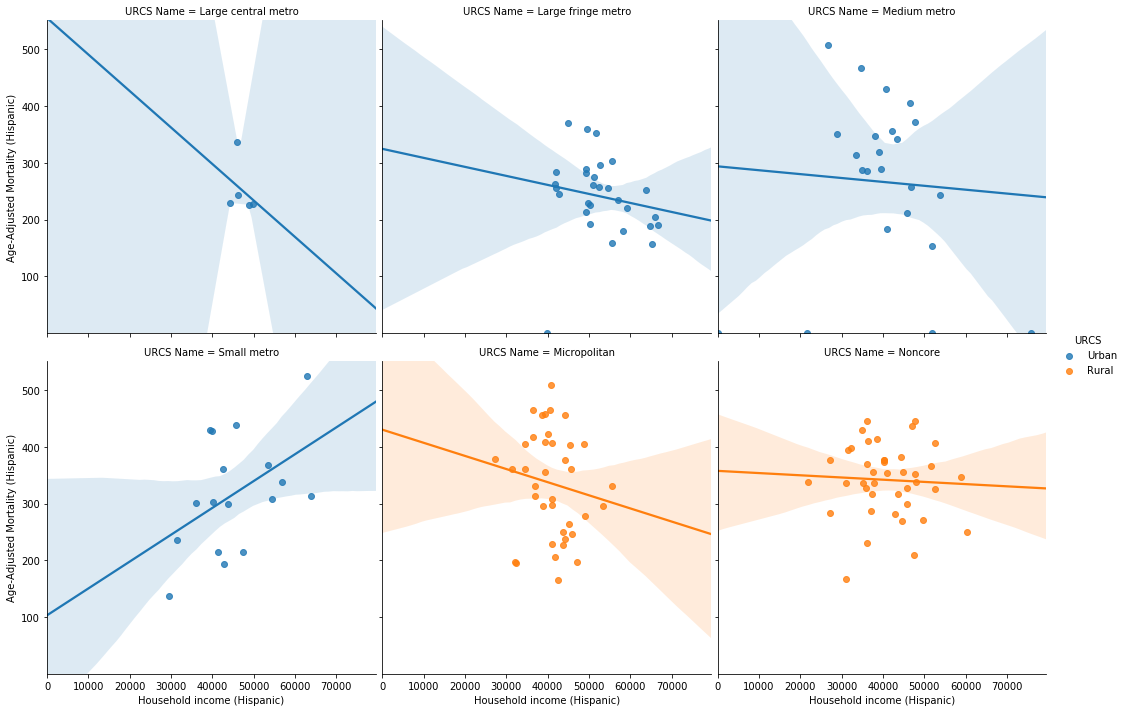

In [91]:
makePanelScatterplot(all_clean_df,"Household income (Hispanic)","Age-Adjusted Mortality (Hispanic)","URCS","URCS Name")

# OLS Regression using multiple independent variables

Using the statsmodels and ols packages we can throw in a number of independent variables against a chosen dependent variable and run a t-test for each independent variable with a null-hypothesis of: "Is the coefficient of the variable statistically different than zero in the model?" In other words, if the t-test fails to have a low enough pvalue then we can reject the variable as contributing to the linear regression model

### The OLS Regression takes column name arguments that cannot contain spaces
So we need to choose which colums we want to use and then create a separate dataframe and rename the column names to prepare the data. We have chosen to further study all Black columns since the scatterplots looked very correlated against AAMR for Income.

In [92]:
# View the columns that contain 'Black'
regex4 = '.*Black.*'
cols_black = [col for col in multi_clean_df.columns if re.match(regex4,col) is not None] 
cols_black

['YPLL Rate (Black)',
 '% LBW (Black)',
 'Teen Birth Rate (Black)',
 'Preventable Hosp. Rate (Black)',
 '% Screened (Black)',
 '% Vaccinated (Black)',
 '% Children in Poverty (Black)',
 '% Drive Alone (Black)',
 'Life Expectancy (Black)',
 'Age-Adjusted Mortality (Black)',
 'Child Mortality Rate (Black)',
 'Infant Mortality Rate (Black)',
 'Household income (Black)']

Review the column names to decide which variables to put into OLS Regression.
This will give us information which independent variables improve the R-squared linear fit and which can be removed. We don't want to take 

In [93]:
# Create an index list to use to delete those columns from our dataframe
indexes = [0,8,10,11]

# Loop through the list of all Columns containing the string "Black" and delete those that we have in our indexes list
for index in sorted(indexes, reverse=True):
    del cols_black[index]
cols_black

['% LBW (Black)',
 'Teen Birth Rate (Black)',
 'Preventable Hosp. Rate (Black)',
 '% Screened (Black)',
 '% Vaccinated (Black)',
 '% Children in Poverty (Black)',
 '% Drive Alone (Black)',
 'Age-Adjusted Mortality (Black)',
 'Household income (Black)']

In [94]:
# Apply the column list as a mask to get back a dataframe with only those columns
black_df = multi_clean_df[cols_black]

In [95]:
# Rename the columns
black_df = black_df.rename(columns={"% LBW (Black)" : "Low_Birth_Weight",
                   "Teen Birth Rate (Black)" : "Teen_Birth_Rate",
                   "Preventable Hosp. Rate (Black)"  : "Prev_Hosp_Rate",
                   "% Screened (Black)"  : "Mammography_Screen_Perct",
                   "% Vaccinated (Black)"  : "Vaccinated_Perct",
                   "% Children in Poverty (Black)"  : "Child_Poverty_Perct",
                   "% Drive Alone (Black)"  : "Drive_Alone_Perct",
                    "Age-Adjusted Mortality (Black)"  : "Age_Adj_Mortality_Rate",
                   "Household income (Black)"  : "Household_Income"     
                   })

In [96]:
# Prepare a clean slice for the most interesting segment: Large fringe metro
black_urban = black_df.loc['Urban']
black_rural = black_df.loc['Rural']
black_suburbs = black_urban.loc['Large fringe metro']
black_suburbs_clean = black_suburbs.dropna()

In [97]:
# Make the model and call the ols function passing our dependent variable first followed by the independent variables
black_model = ols("Age_Adj_Mortality_Rate ~ Household_Income + Prev_Hosp_Rate + Child_Poverty_Perct + Vaccinated_Perct", data=black_rural).fit()
print(black_model.summary())

                              OLS Regression Results                              
Dep. Variable:     Age_Adj_Mortality_Rate   R-squared:                       0.229
Model:                                OLS   Adj. R-squared:                  0.135
Method:                     Least Squares   F-statistic:                     2.446
Date:                    Sat, 01 Feb 2020   Prob (F-statistic):             0.0658
Time:                            09:24:13   Log-Likelihood:                -227.80
No. Observations:                      38   AIC:                             465.6
Df Residuals:                          33   BIC:                             473.8
Df Model:                               4                                         
Covariance Type:                nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------

#### Reviewing first the R-squared value against the Adj. R-squared value we see that the Adj. number is lower - this indicates that we have put independent variables into the model that don't contribute and their coefficient should be zero. Next, looking at the P>|t| column we see that this is the pvalue for the neighboring t-test 't' column for our above mentioned null-hypothesis. Any pvalue > 0.05 states that we cannot reject the null hypothesis of saying that the coefficient should be zero. 

### Only the Child Poverty Perct (pvalue= 0.031) meets our criteria, although the Household Income is close at 0.068

### Plot partial Regression plots to visualize the data

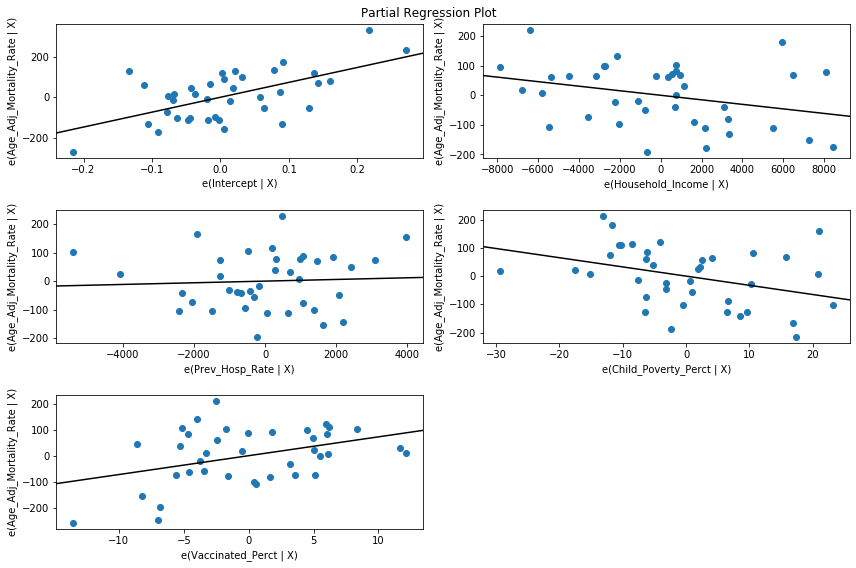

In [98]:
# Plot partial regression plots using the statsmodel package
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_partregress_grid(black_model, fig=fig)

### Honestly viewing the partial regression plots I would not have picked Child Poverty Perct to have been significant.

### The final plot from ols is the combined partial regression plot. It shows that the choosen independent variable of Household Income does not strongly correlate against the AAMR dependent variable

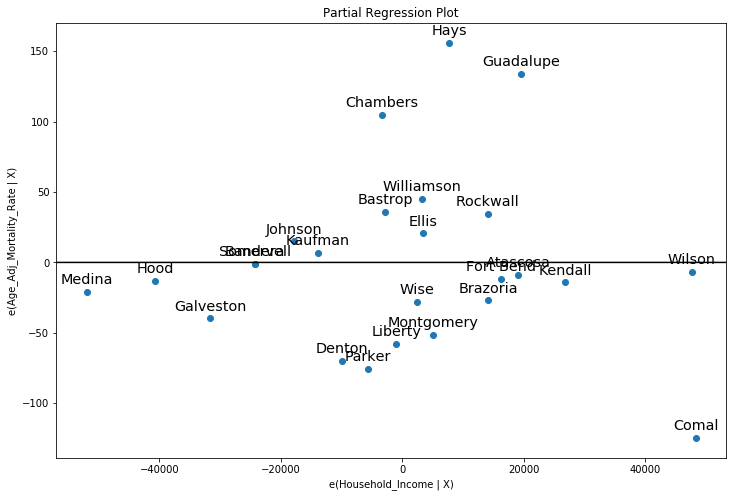

In [99]:
fig, ax = plt.subplots(figsize=(12,8))
fig = sm.graphics.plot_partregress("Age_Adj_Mortality_Rate", "Household_Income", ["Teen_Birth_Rate", "Prev_Hosp_Rate", "Child_Poverty_Perct","Vaccinated_Perct"],  ax=ax, data=black_suburbs_clean)


# Age adjusted Mortality (Deaths/100k) for Diabetics

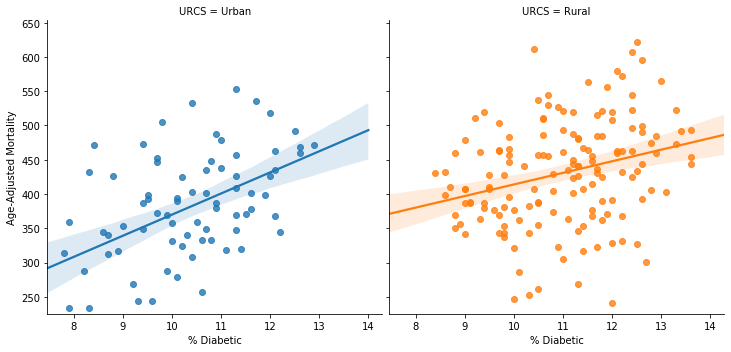

In [100]:
makePanelScatterplot(all_clean_df,"% Diabetic","Age-Adjusted Mortality","URCS","URCS")

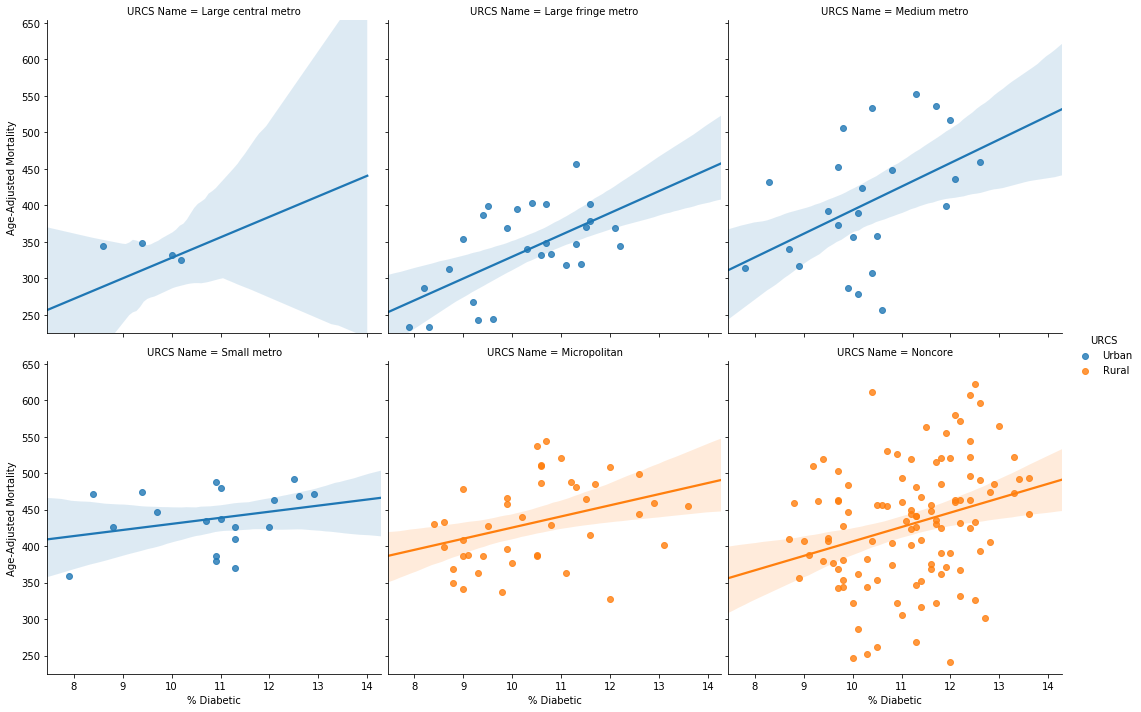

In [101]:
makePanelScatterplot(all_clean_df,"% Diabetic","Age-Adjusted Mortality","URCS","URCS Name")

# Age adjusted Mortality (Deaths/100k) for Smokers

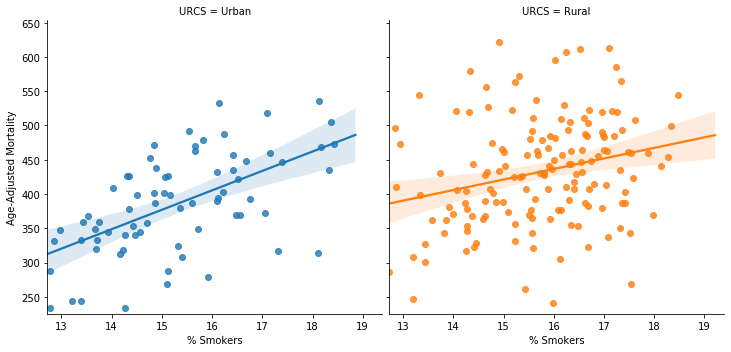

In [102]:
makePanelScatterplot(all_clean_df,"% Smokers","Age-Adjusted Mortality","URCS","URCS")

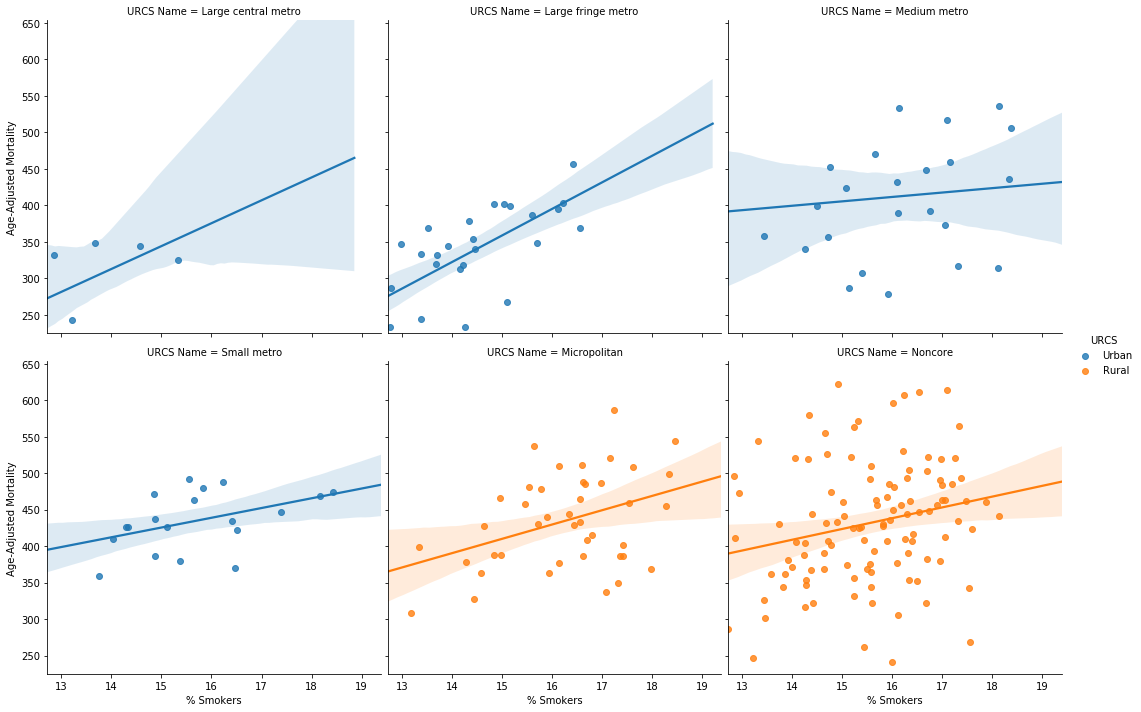

In [103]:
makePanelScatterplot(all_clean_df,"% Smokers","Age-Adjusted Mortality","URCS","URCS Name")

# Age adjusted Mortality (Deaths/100k) for Physically Inactive

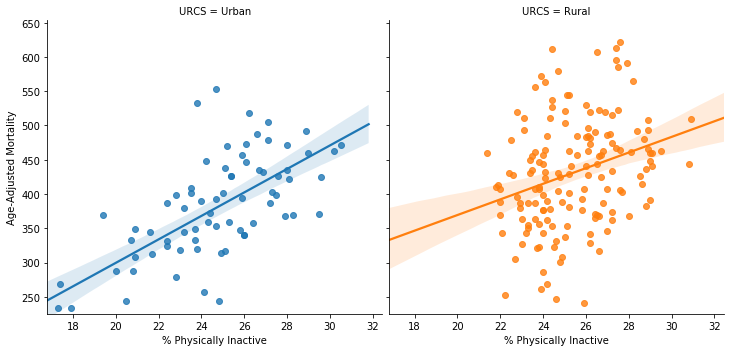

In [104]:
makePanelScatterplot(all_clean_df,"% Physically Inactive","Age-Adjusted Mortality","URCS","URCS")

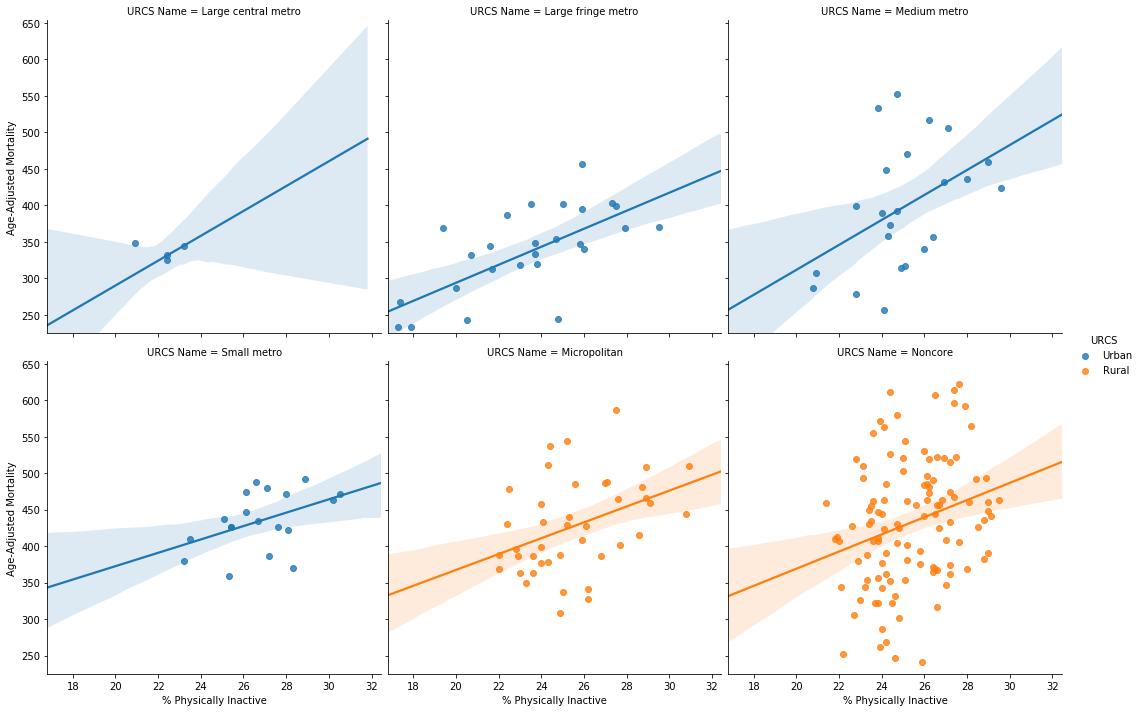

In [105]:
makePanelScatterplot(all_clean_df,"% Physically Inactive","Age-Adjusted Mortality","URCS","URCS Name")

# Age adjusted Mortality (Deaths/100k) for Food Insecurity

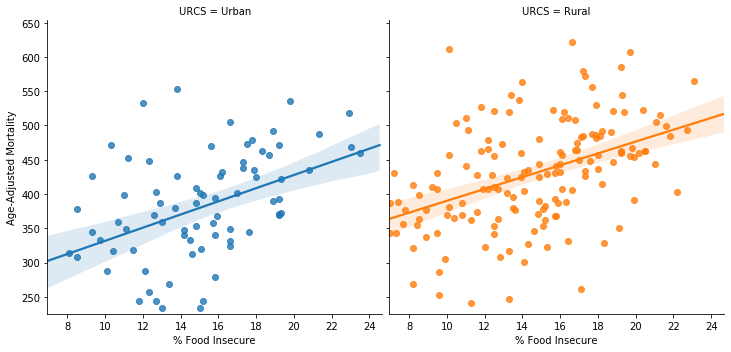

In [106]:
makePanelScatterplot(all_clean_df,"% Food Insecure","Age-Adjusted Mortality","URCS","URCS")

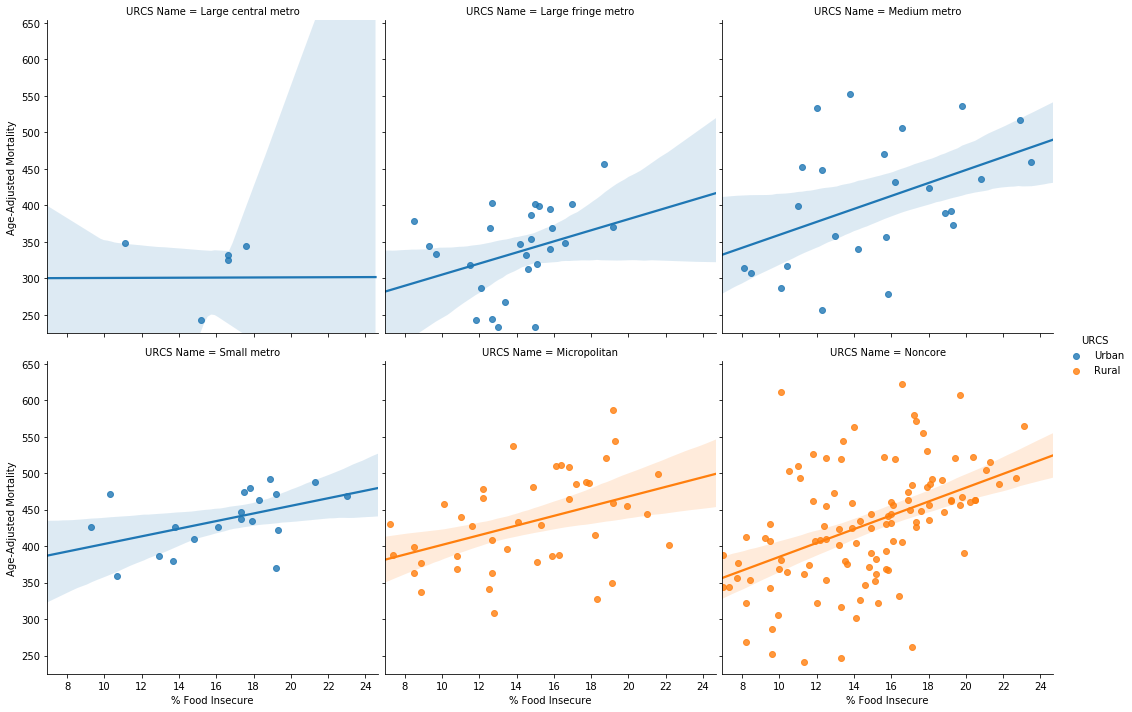

In [107]:
makePanelScatterplot(all_clean_df,"% Food Insecure","Age-Adjusted Mortality","URCS","URCS Name")

# Age adjusted Mortality (Deaths/100k) for Children in Poverty

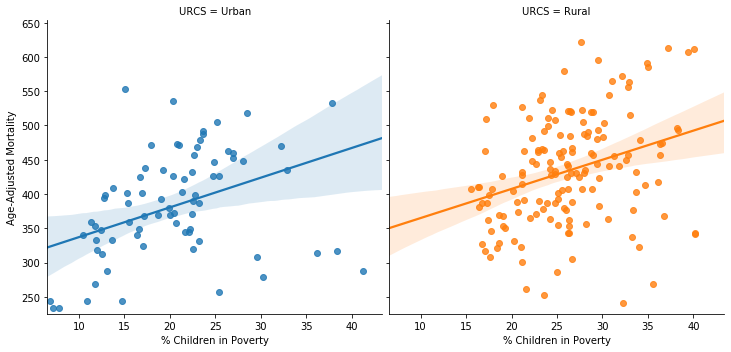

In [108]:
makePanelScatterplot(all_clean_df,"% Children in Poverty","Age-Adjusted Mortality","URCS","URCS")

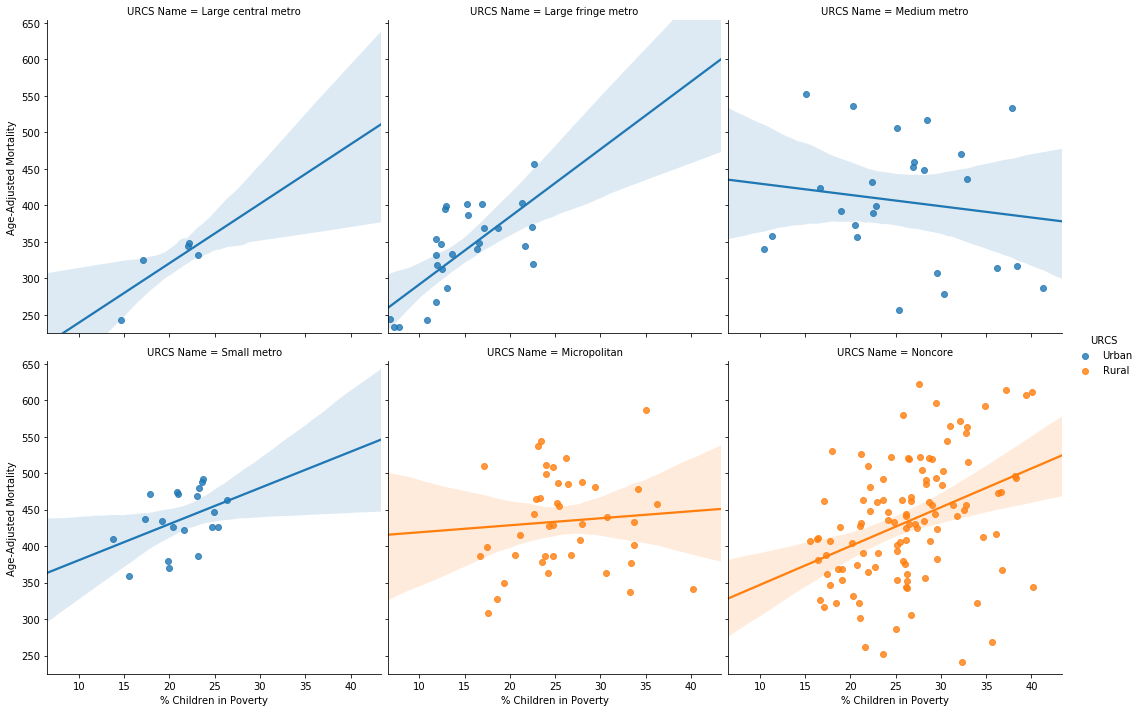

In [109]:
makePanelScatterplot(all_clean_df,"% Children in Poverty","Age-Adjusted Mortality","URCS","URCS Name")

# Age adjusted Mortality (Deaths/100k) vs. Teen Birth Rate

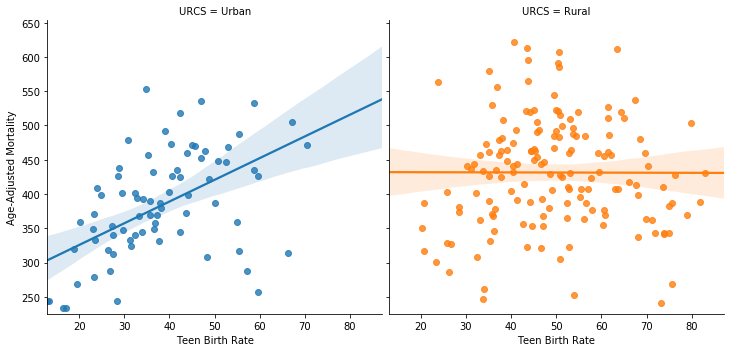

In [110]:
makePanelScatterplot(all_clean_df,"Teen Birth Rate","Age-Adjusted Mortality","URCS","URCS")

In [111]:
olsRegressionAnalysis(urban_clean_df,"urban_clean_df","Age-Adjusted Mortality","Teen Birth Rate")

Age-Adjusted Mortality fitted against Teen Birth Rate     using urban_clean_df dataframe:

We have 78 rows left after dropping Null values

                              OLS Regression Results                              
Dep. Variable:     Age_Adjusted_Mortality   R-squared:                       0.285
Model:                                OLS   Adj. R-squared:                  0.275
Method:                     Least Squares   F-statistic:                     30.26
Date:                    Sat, 01 Feb 2020   Prob (F-statistic):           4.88e-07
Time:                            09:24:28   Log-Likelihood:                -439.61
No. Observations:                      78   AIC:                             883.2
Df Residuals:                          76   BIC:                             887.9
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                      coef    

### The R-Squared value for Urban  AAMR vs. Teen Birth Rate is 0.285 which shows a relationship 
The pvalue for the t-test of Urban Teen Birth Rate vs. AAMR (pvalue = 0) shows that we cannot reject the null-hypothesis that the coefficient of the Teen Birth Rate variable is zero - meaning there is a relationship between the two variables - although we have a warning due to the low n of 17 with only 15 residuals.

In [112]:
olsRegressionAnalysis(rural_clean_df,"rural_clean_df","Age-Adjusted Mortality","Teen Birth Rate")

Age-Adjusted Mortality fitted against Teen Birth Rate     using rural_clean_df dataframe:

We have 156 rows left after dropping Null values

                              OLS Regression Results                              
Dep. Variable:     Age_Adjusted_Mortality   R-squared:                       0.000
Model:                                OLS   Adj. R-squared:                 -0.006
Method:                     Least Squares   F-statistic:                  0.001156
Date:                    Sat, 01 Feb 2020   Prob (F-statistic):              0.973
Time:                            09:24:28   Log-Likelihood:                -902.48
No. Observations:                     156   AIC:                             1809.
Df Residuals:                         154   BIC:                             1815.
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                      coef   

### The R-Squared value for Rural  AAMR vs. Teen Birth Rate is 0.000 which shows no relationship 
The pvalue for the t-test of Rural Teen Birth Rate vs. AAMR (pvalue = .973) shows that we cannot reject the null-hypothesis that the coefficient of the Teen Birth Rate variable is zero - meaning there is no relationship between the two variables.

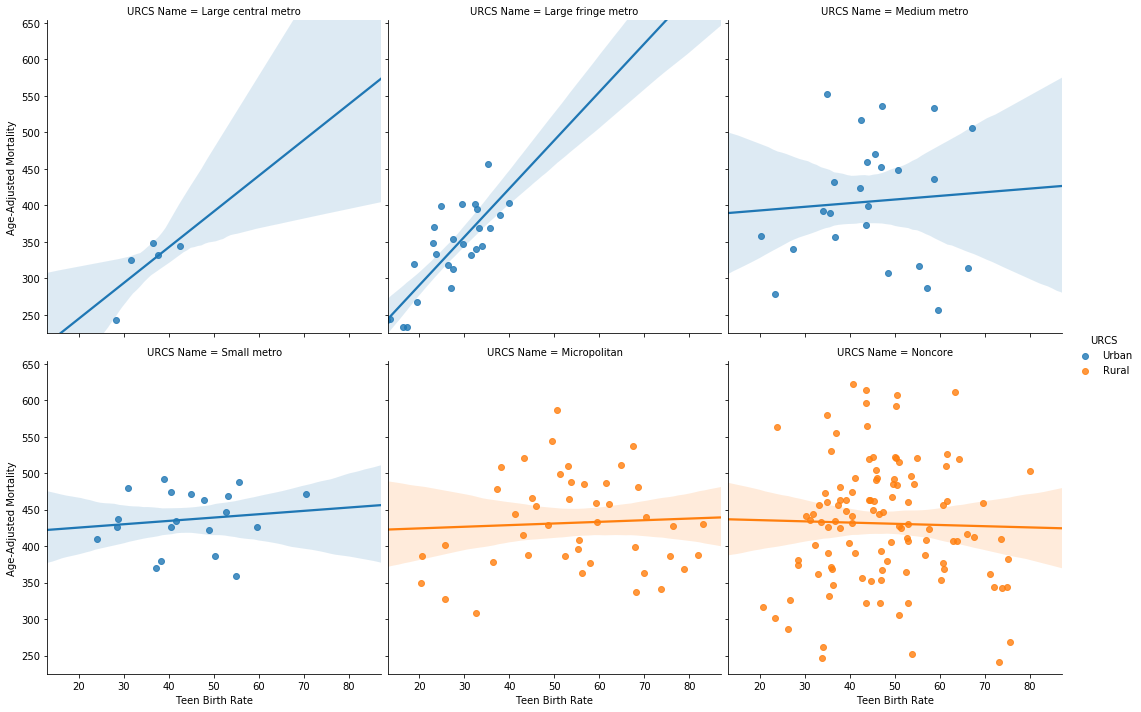

In [114]:
makePanelScatterplot(all_clean_df,"Teen Birth Rate","Age-Adjusted Mortality","URCS","URCS Name")

In [ ]:
olsRegressionAnalysis(lfm_df,"lfm_clean_df","Age-Adjusted Mortality","Teen Birth Rate")

### The R-Squared value for Large fringe metro  AAMR vs. Teen Birth Rate is 0.678 which shows a strong relationship 
The pvalue for the t-test of Rural Teen Birth Rate vs. AAMR (pvalue = 0) shows that we can reject the null-hypothesis that the coefficient of the Teen Birth Rate variable is zero - meaning there is a relationship between the two variables.

# Age adjusted Mortality (Deaths/100k) vs. Teen Birth Rate (Black)

In [ ]:
makePanelScatterplot(all_clean_df,"Teen Birth Rate (Black)","Age-Adjusted Mortality","URCS","URCS")

In [ ]:
makePanelScatterplot(all_clean_df,"Teen Birth Rate (Black)","Age-Adjusted Mortality","URCS","URCS Name")

# Age adjusted Mortality (Deaths/100k) vs. Teen Birth Rate (White)

In [ ]:
makePanelScatterplot(all_clean_df,"Teen Birth Rate (White)","Age-Adjusted Mortality","URCS","URCS")

In [ ]:
makePanelScatterplot(all_clean_df,"Teen Birth Rate (White)","Age-Adjusted Mortality","URCS","URCS Name")

In [ ]:
olsRegressionAnalysis(lfm_df,"lfm_clean_df","Age-Adjusted Mortality","Teen Birth Rate (White)")

### The R-Squared value for Large fringe metro  AAMR vs. Teen Birth Rate (White) is 0.735 which shows a relationship 
The pvalue for the t-test of Large fringe metro Teen Birth Rate vs. AAMR (pvalue = 0) shows that we can reject the null-hypothesis that the coefficient of the Teen Birth Rate variable is zero - meaning there is a stron relationship between the two variables

# Age adjusted Mortality (Deaths/100k) vs. Teen Birth Rate (Hispanic)

In [ ]:
makePanelScatterplot(all_clean_df,"Teen Birth Rate (Hispanic)","Age-Adjusted Mortality","URCS","URCS")

In [ ]:
makePanelScatterplot(all_clean_df,"Teen Birth Rate (Hispanic)","Age-Adjusted Mortality","URCS","URCS Name")